# Optymalizacja ciągła
## Rozwinięcia Stochastic Gradient Descent

Zadania te przypominać będą laboratorium ze zwykłęgo SGD gdyż zasadniczo - efekt algorytmu jest ten sam, jedynie implementacja jest odrobinkę dłuższa.

## Dependencje:
```
pip3 install --user JSAnimation
```

### Ćwiczenie 0.5 (trochę powtórki)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from JSAnimation import IPython_display
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import sklearn.datasets as ds
from sklearn.linear_model import LinearRegression
%matplotlib inline
from helpers import *

Przypomnijmy omawiany już przykład regresji liniowej prostej $y=ax+b$ czyli takiej z tylko 1 zmienną objaśniającą ($x$). Problem nie jest trudny, ale ponieważ optymalizowana przestrzeń jest dwuwymiarowa ($a$ i $b$: waga dla $x$ oraz stała) będziemy mogli zwizualizować proces optymalizacyjny.

Wygenerujmy sztuczne dane do jednowymiarowej regresji liniowej

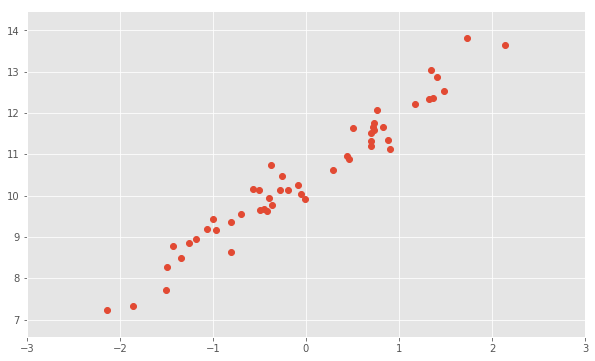

In [2]:
X_train,y_train = generate_data()

Korzystając z naszej wcześniejszej wiedzy o mnożeniu wektorów,  równanie regresji wygląda w następujący sposób:
$$\hat{y}=\beta_0+\mathsf{x}^T\mathsf{\beta} $$
Aby jeszcze uprościć ten zapis dodajemy do wektora $\mathsf{x}$ sztuczną, dodatkową wartość równą jeden. Pozwala nam to na wpisanie stałej $\beta_0$ do wektora $\beta$ i dalsze uproszczenie zapisu:
$$\hat{y}=\mathsf{x}^T\beta $$
Dopiszmy więc do naszej macierzy `X_train` nową kolumnę pełną jedynek, aby móc skorzystać z uproszczonej notacji

In [3]:
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]

Funkcję celu to błąd kwardatowy $$MSE = \frac{1}{n}\sum_{i=1}^n (y-\hat{y})^2$$

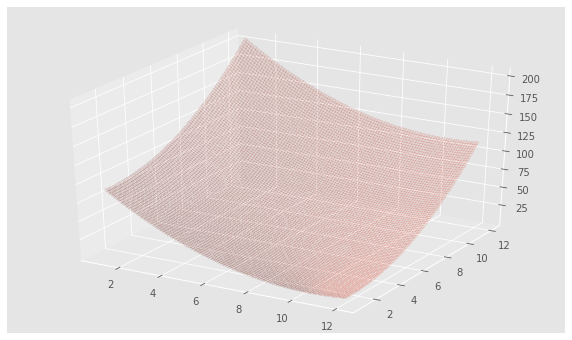

In [4]:
def cost_function(x, y, beta):
    return np.mean((np.dot(x, beta) - y) ** 2)

#Wizualizacja błędu
plot_3d_linear_regression(X_train_bias, y_train, cost_function)

Jak widać problem jest wypukły (no tak idealnie nie widać). Zwróć uwagę, że na osiach wykresu masz wagi regresji liniowej: odpowiednio $a$ i $b$ we wzorze $\hat{y}=ax+b$. Wysokość wykresu opisuje błąd popełniany przez regresję na całym zbiorze treningowym dla danego ustawienia wag regresji. Naszym zadaniem jest znalezienie najlepszej regresji czyli takich wag $a$ i $b$, aby wzór $\hat{y}=ax+b$ popełniał jak najmniejsze błędy.

Uzupełnij poniższą implementację algortmu spadku wzdłuż gradientu.

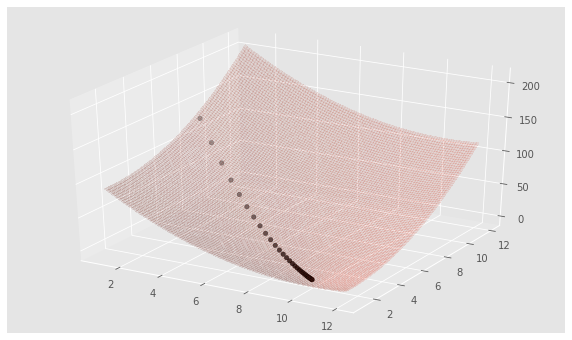

Cost at minimum 0.37282470172114013


In [10]:
def gradient_descent(X, y, beta0, iters, alpha):
    beta = np.array(beta0)    # wartość początkowa
    history = []      # historyczne rozwiązania (kolejne wektory beta)
    costs = []        # historyczne jakości rozwiązań
    
    for i in range(iters):
        #Dodaj informacje historyczne (na potrzeby rysowania wykresu)
        history.append(beta)
        cost = cost_function(X, y, beta)
        costs.append(cost)
        #Właściwa część algorytmu - TWÓJ KOD TUTAJ
        beta = beta - alpha * (2 * X.T @ (X @ beta - y)) 
    return history, costs

history_gd, costs = gradient_descent(X_train_bias, y_train, 
                                        beta0 = [1.2, 8], 
                                        iters = 30, 
                                        alpha = 0.001)
plot_3d_linear_regression(X_train_bias, y_train, cost_function, history_gd)
print("Cost at minimum", min(costs))

Teraz pora na implementację algorytmu stochastycznego spadku wzdłuż gradientu z opcjonalnym **momentum** jako parametrem. Zaimplementuj algorytm także w wersji NAG (Nesterov Accelerated Gradient). Dobrą wartością 'na oko' dla współczynnika momentum jest 0.9 (duża bezwładność).

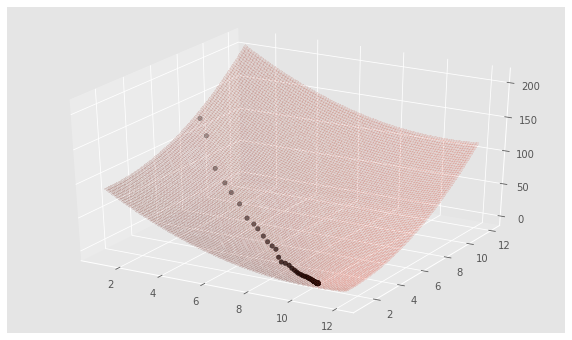

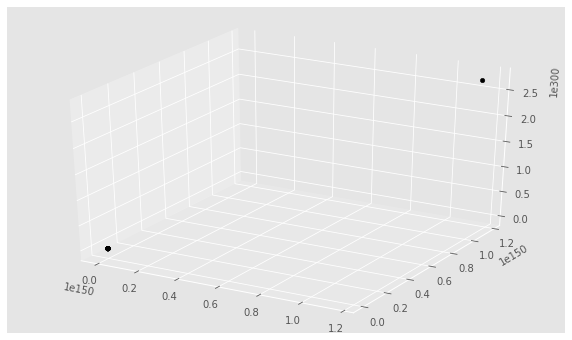

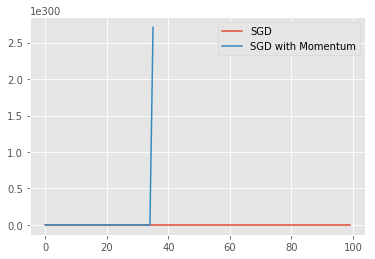

Cost at minimum 0.1157474100085401


In [18]:
def stochastic_gradient_descent(X, y, beta0, iters, alpha, momentum_mu=0, nesterov=False):
    beta = np.array(beta0)    # wartość początkowa
    momentum = np.zeros_like(beta)
    history = []      # historyczne rozwiązania (kolejne wektory beta)
    costs = []        # historyczne jakości rozwiązań
    
    for i in range(iters):
        #Dodaj informacje historyczne (na potrzeby rysowania wykresu)
        if i % 10 == 0:
            history.append(beta)
            cost = cost_function(X, y, beta)
            costs.append(cost)
        #Właściwa część algorytmu - TWÓJ KOD TUTAJ
        j = np.random.randint(y.size)
        
        if nesterov and momentum_mu > 0:
            #KOD Nesterov momuentum
            gradient = 2 * X[j] * (X[j] @ (beta + momentum * momentum_mu) - y[j]) 
            momentum = momentum_mu * momentum + gradient
        else:
            #KOD Zwykłego momentum
            momentum = momentum_mu * momentum + 2 * X[j] * (X[j] @ beta - y[j])
        beta = beta - alpha * momentum
    return history, costs
np.random.seed(1)
history_sgd, costs = stochastic_gradient_descent(X_train_bias, y_train, 
                                        beta0 = [1.2, 8], 
                                        iters = 1000, 
                                        alpha = 0.005)
history_momentum, costs_momentum = stochastic_gradient_descent(X_train_bias, y_train, 
                                        beta0 = [1.2, 8], 
                                        iters = 1000, 
                                        alpha = 0.005,
                                        momentum_mu=0.9,
                                        nesterov=True)

plot_3d_linear_regression(X_train_bias, y_train, cost_function, history_sgd)
plot_3d_linear_regression(X_train_bias, y_train, cost_function, history_momentum)

plt.plot(costs,label="SGD")
plt.plot(costs_momentum,label="SGD with Momentum")
plt.legend()
plt.show()
print("Cost at minimum", min(costs))

Jeśli wszystko zostało dobrze zaimplementowane, naszym oczom powinien pokazać się wykres pokazujący jak bardzo momentum przyspiszyło nasz algorytm. Nie jest to niestety gwarantowany efekt, ale częśto warto spróbować obydwu i wybrać lepsze.


Poniżej masz gotowy kod pokazujący animacje procesu optymalizacyjnego. Podstaw pod `history` odpowiednią wartość aby zobaczyć jak wyglądają kolejne rozwiązania problemu regresji w algorymach SGD i SGD z Momentum. 


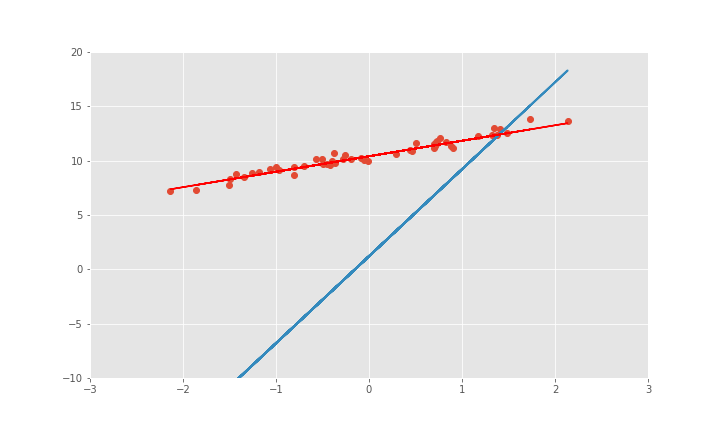
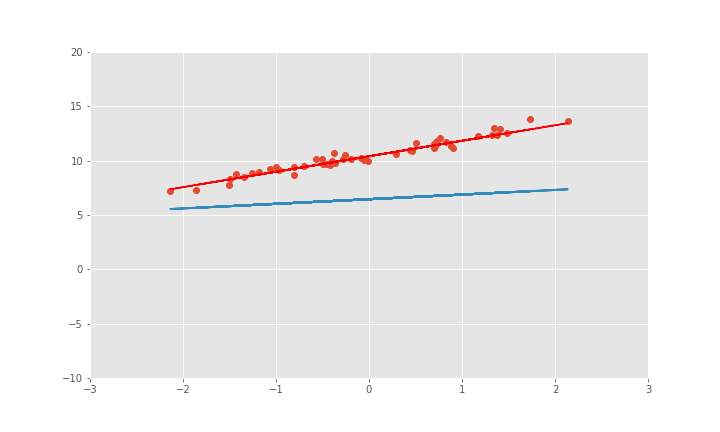
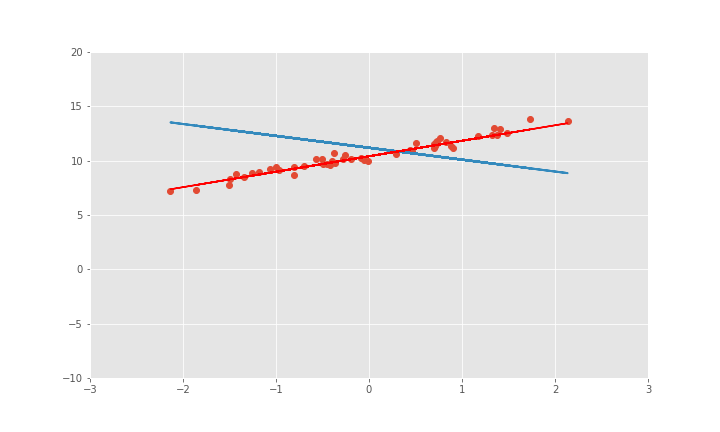
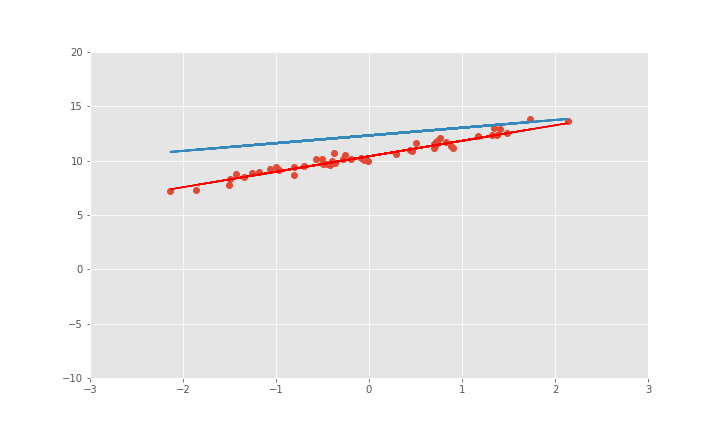
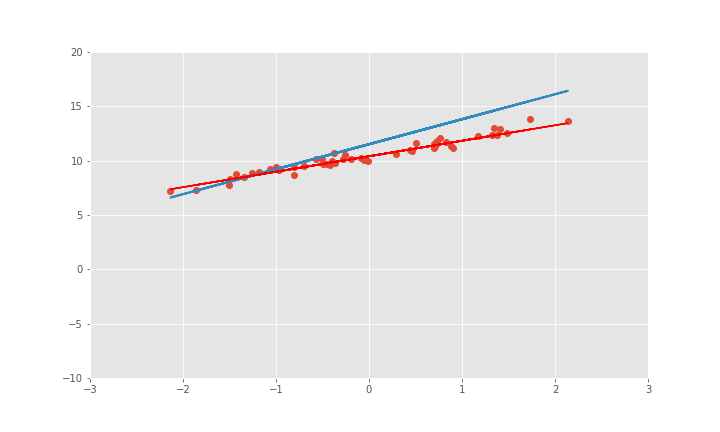
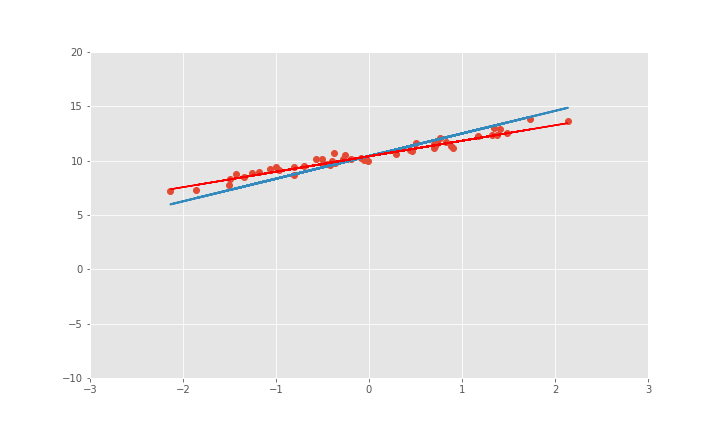
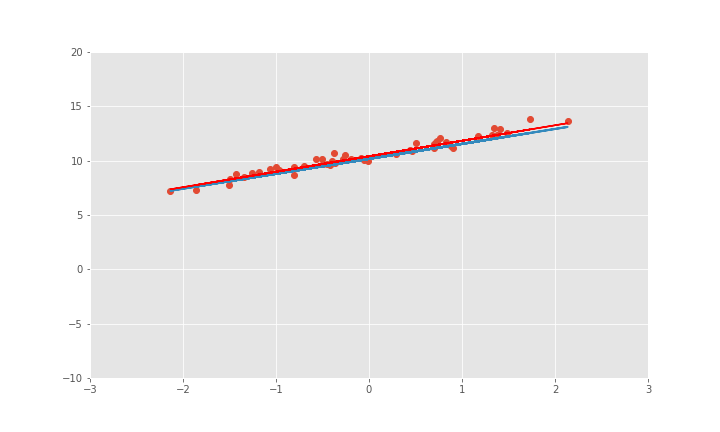
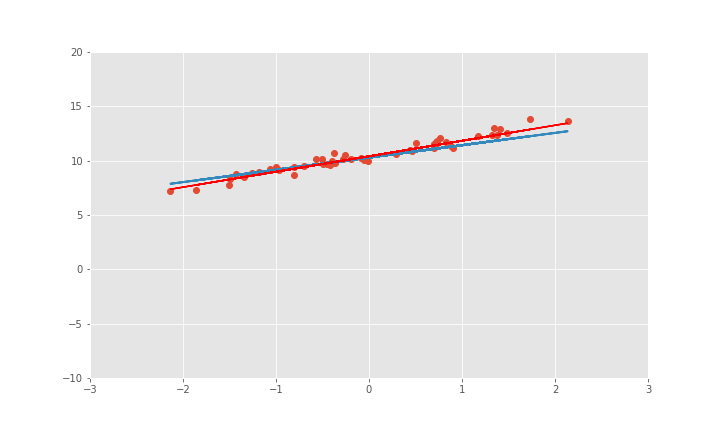
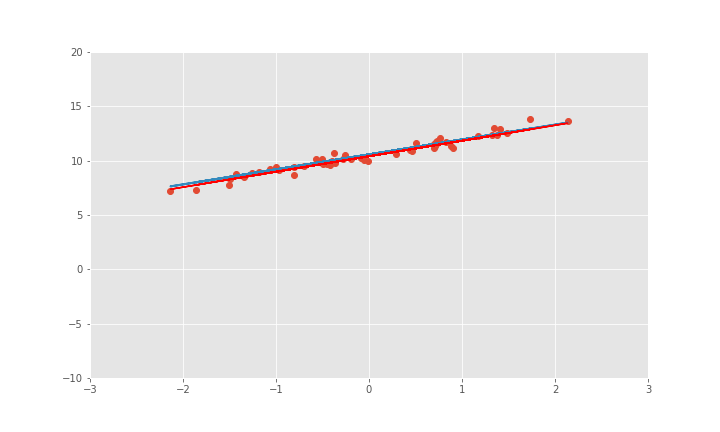
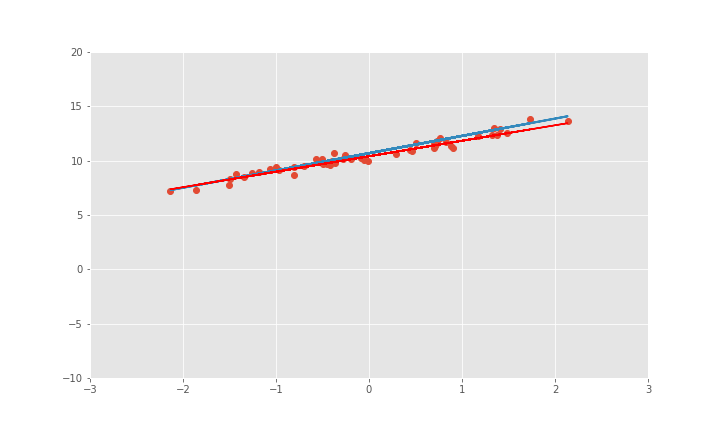
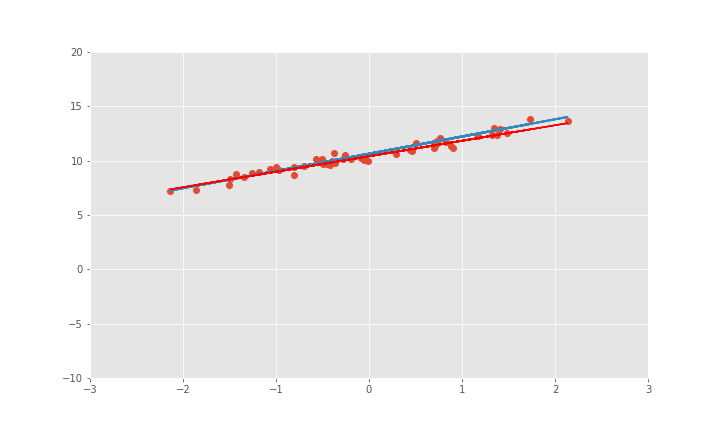
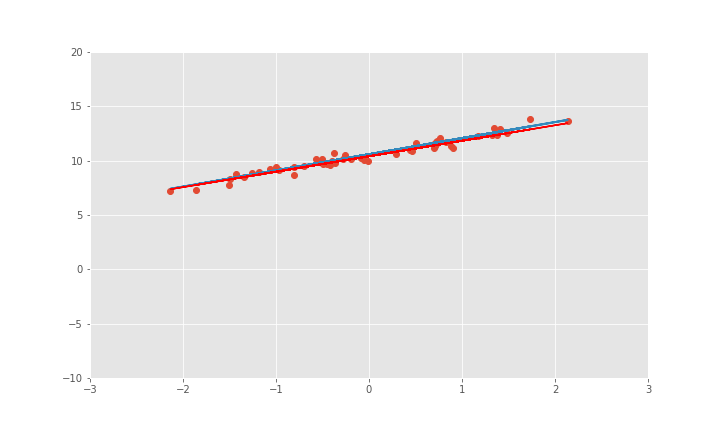
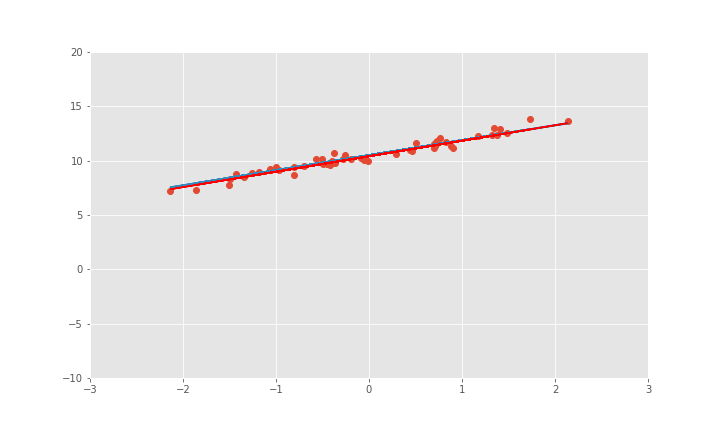
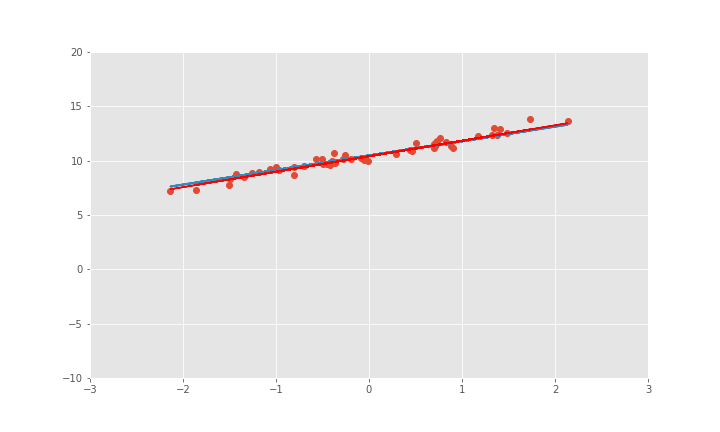
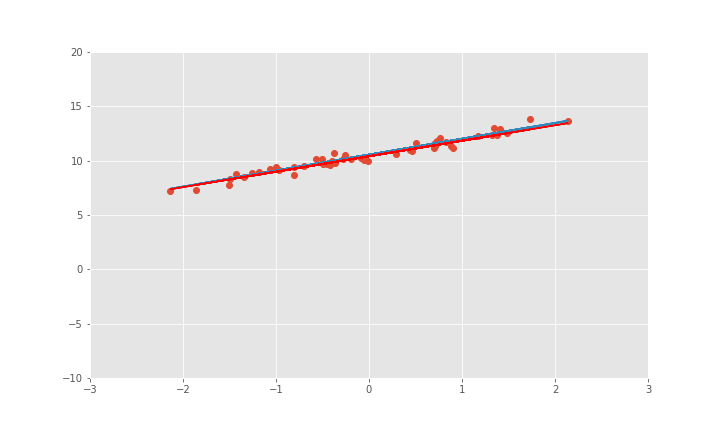
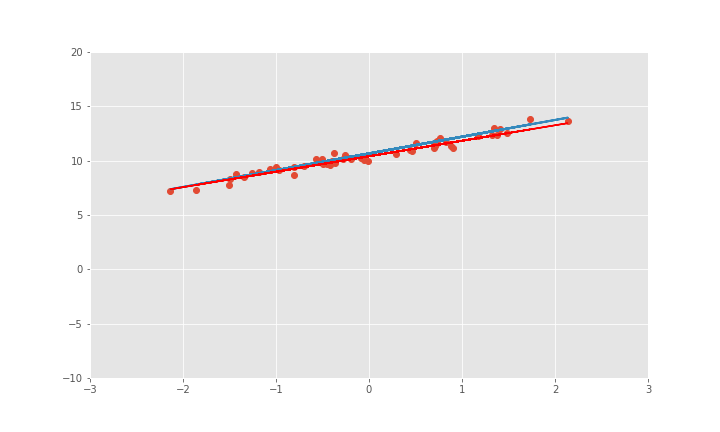
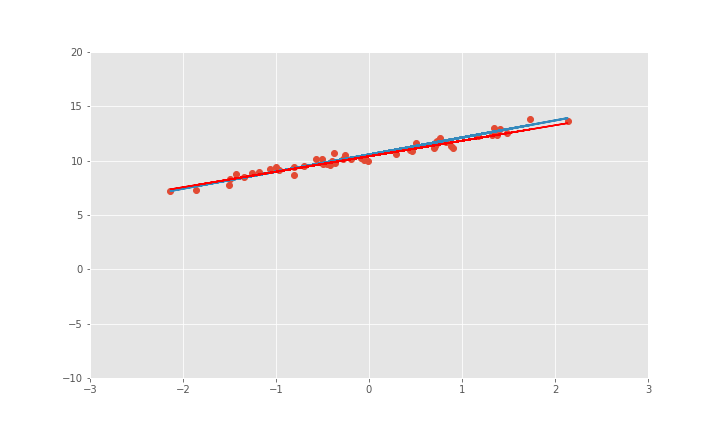
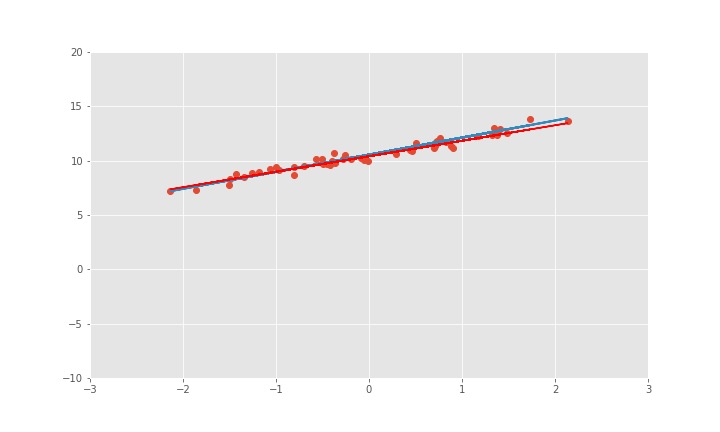
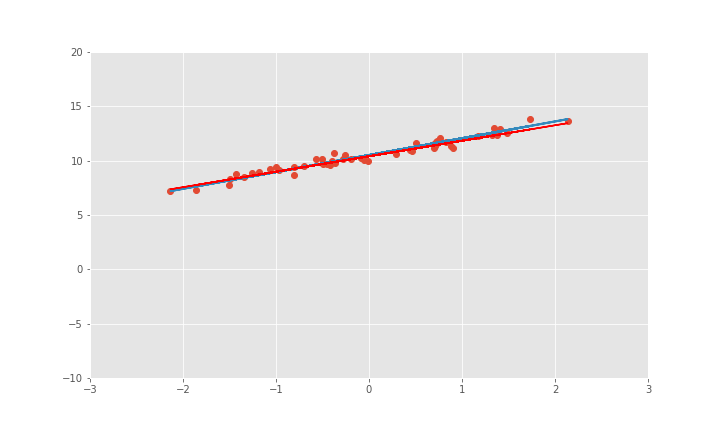
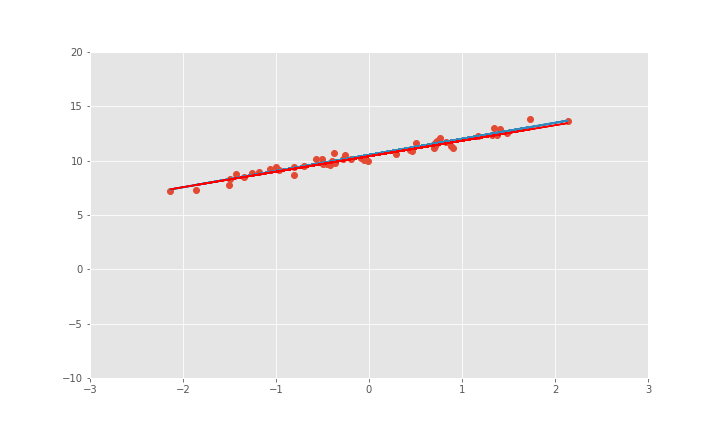
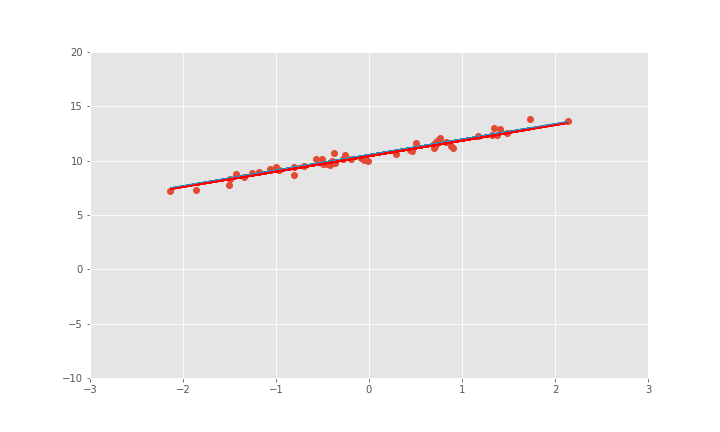
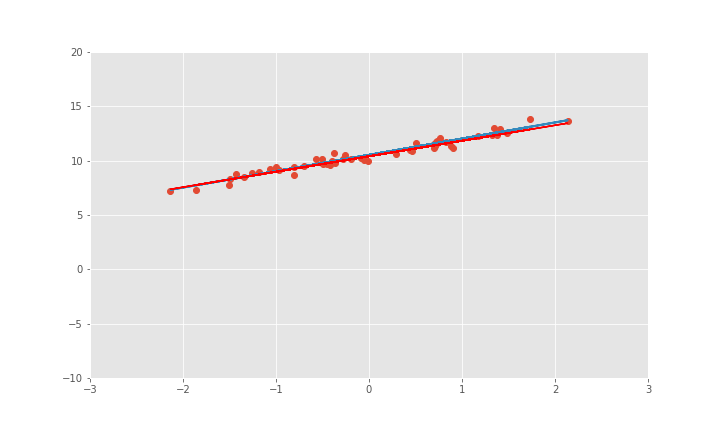
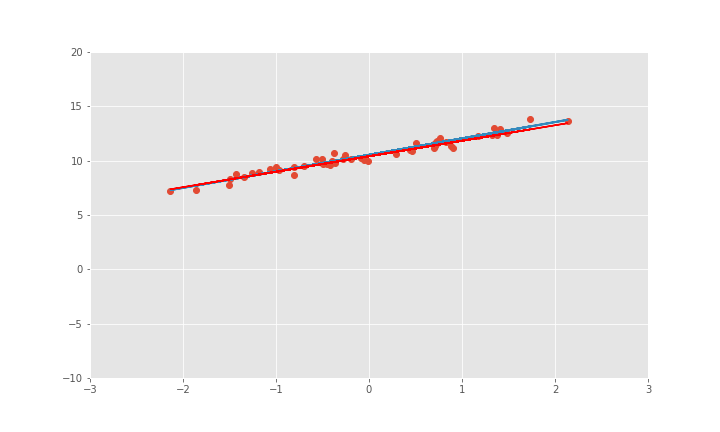
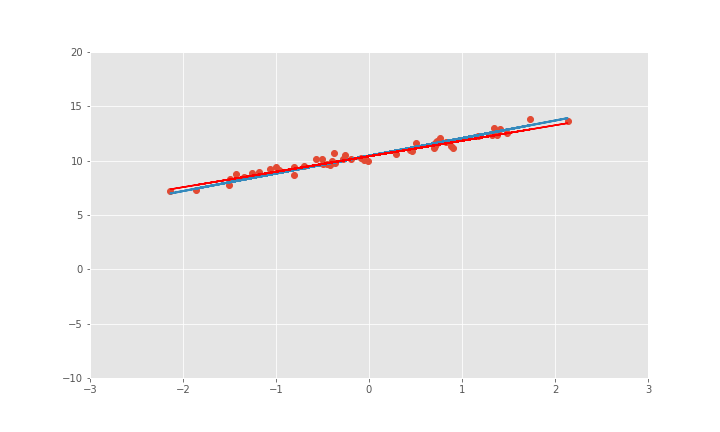
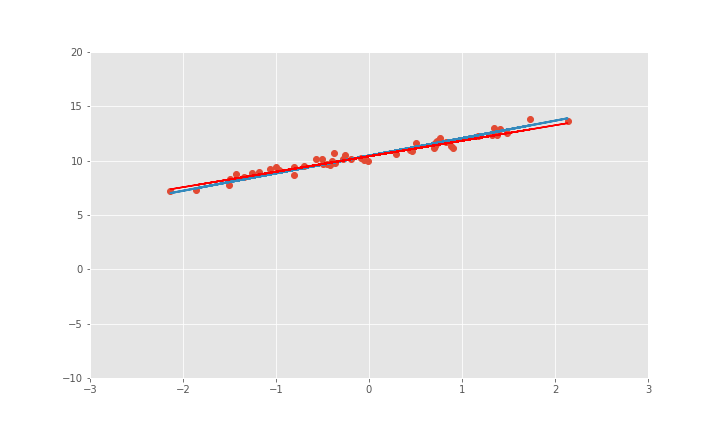
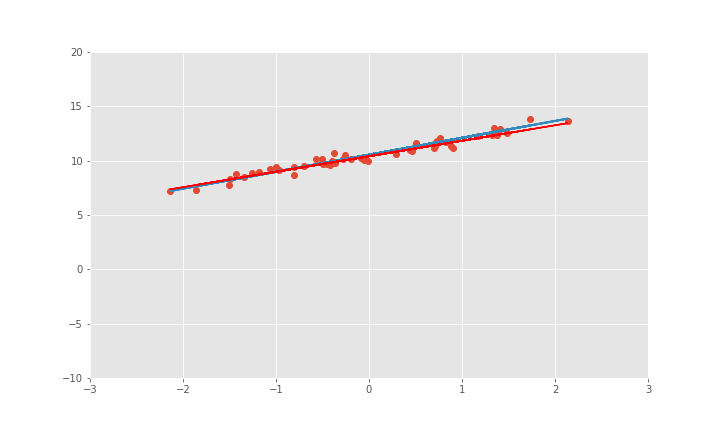
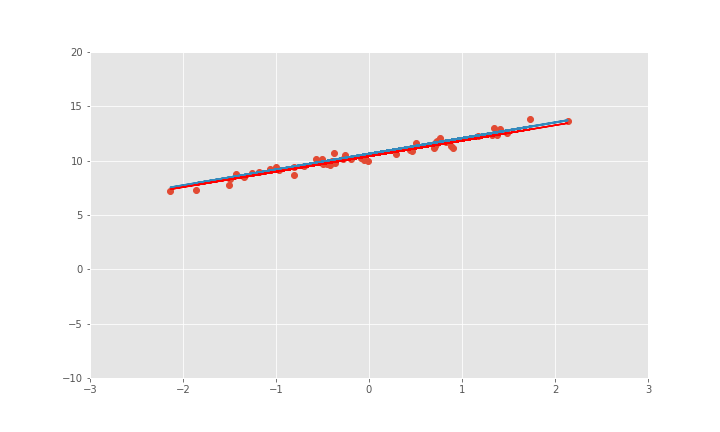
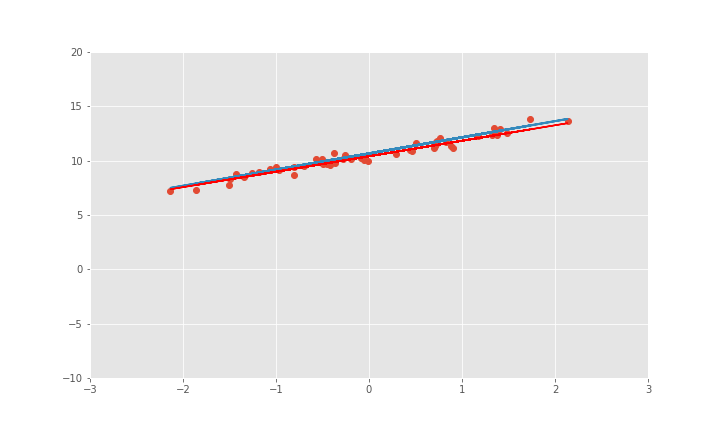
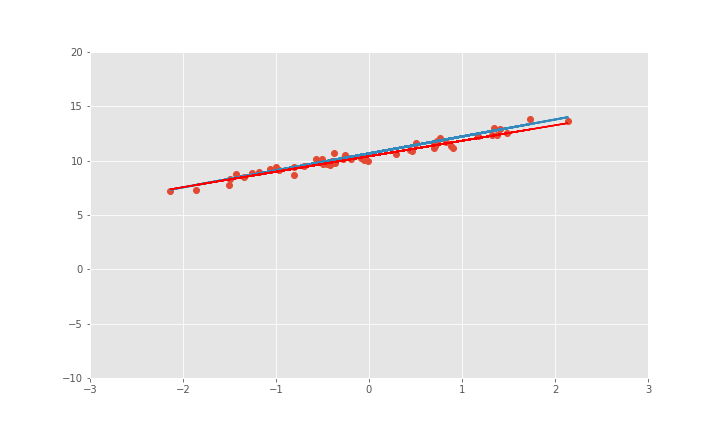
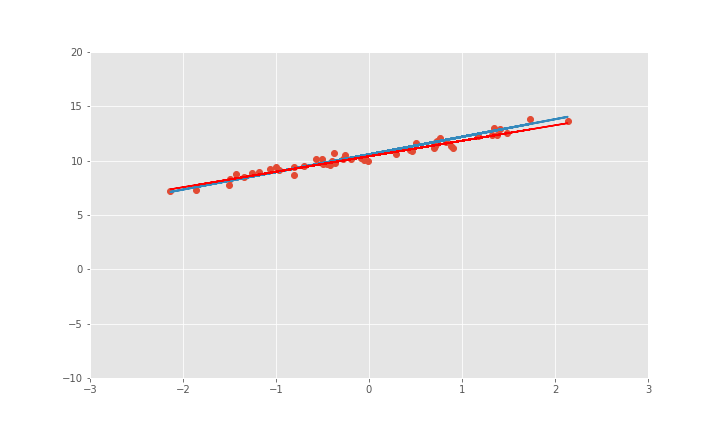
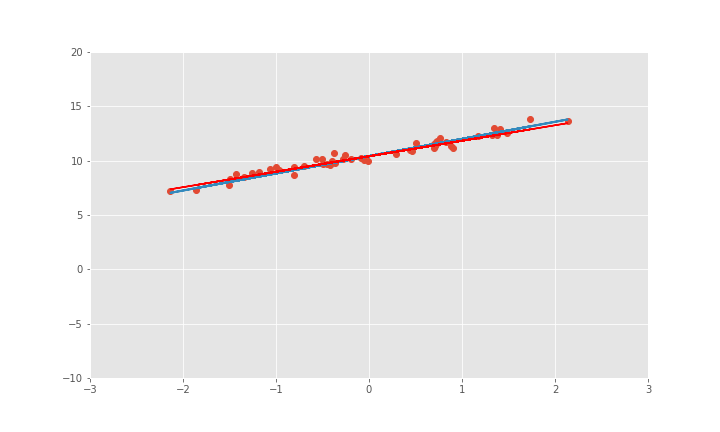
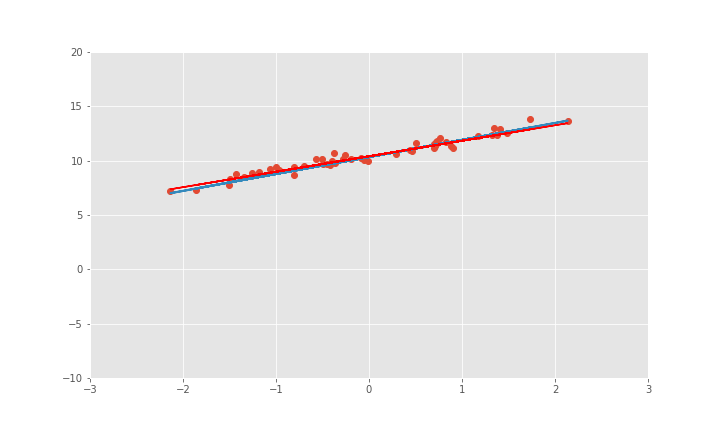
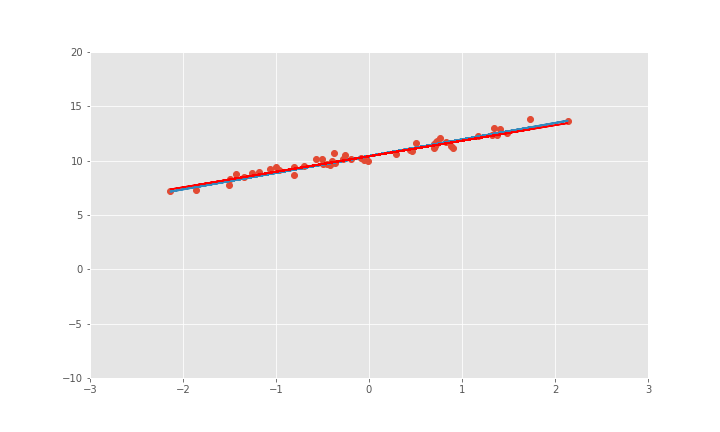
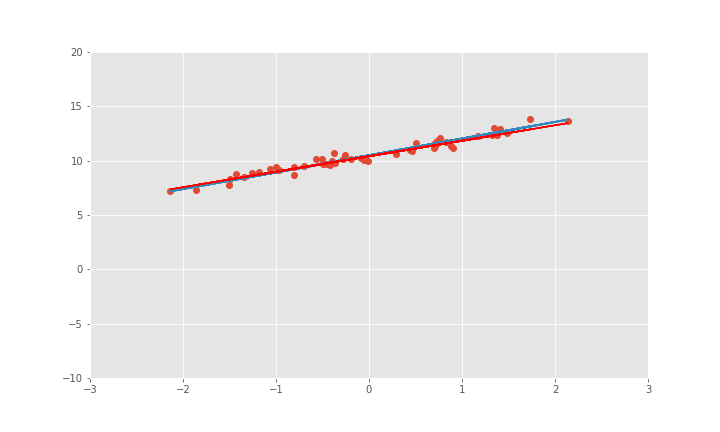
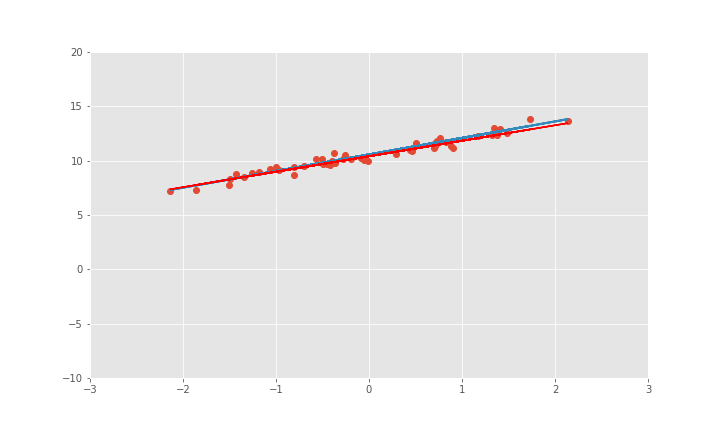
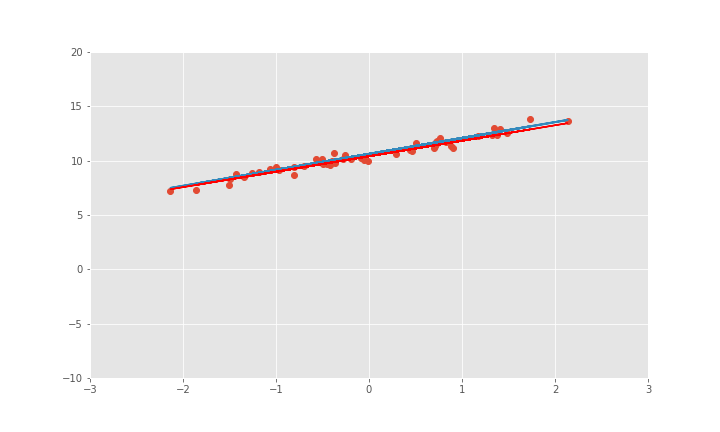
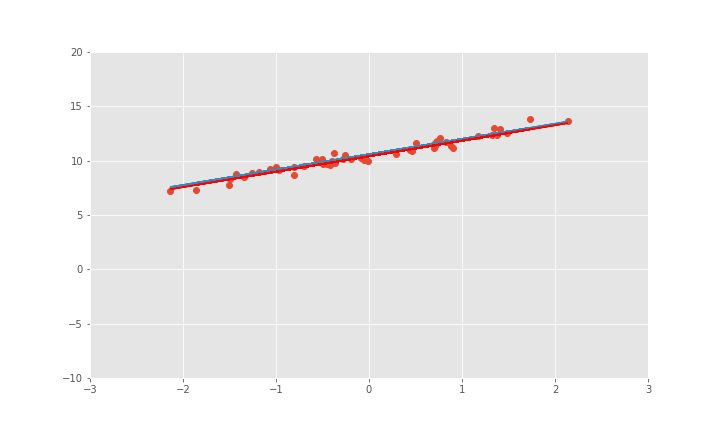
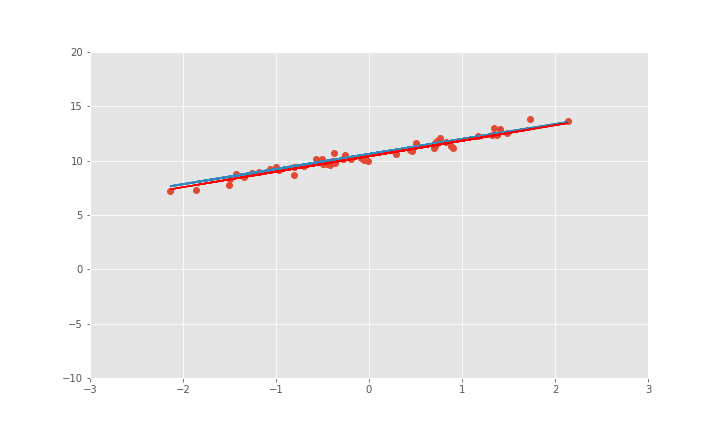
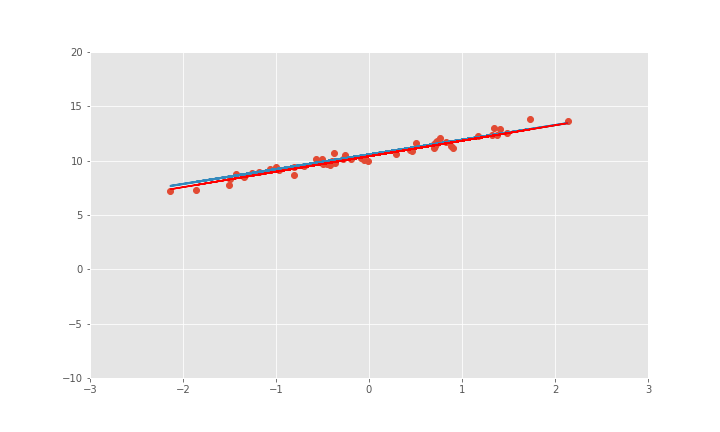
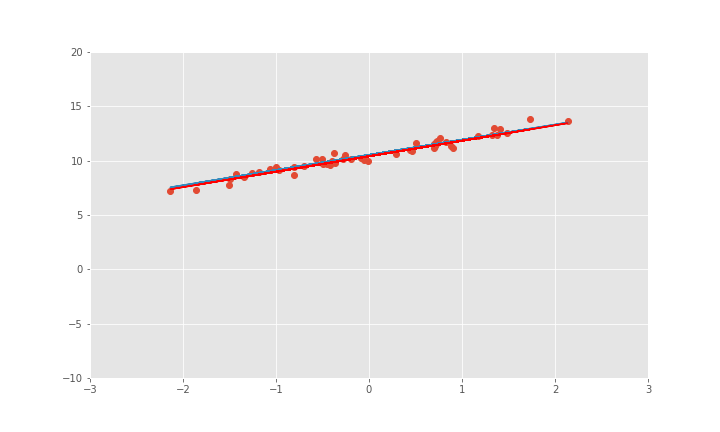
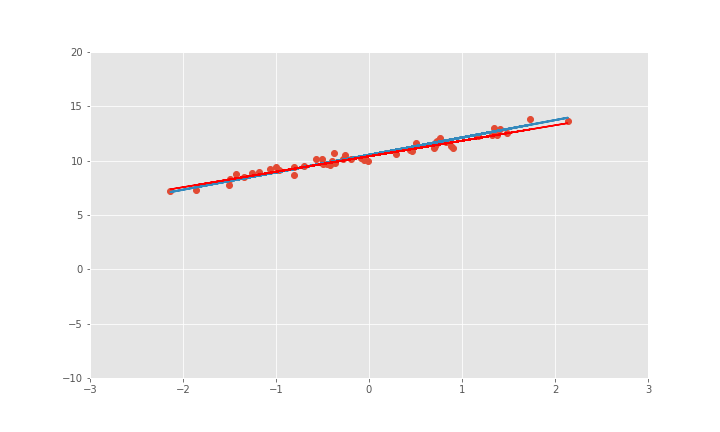
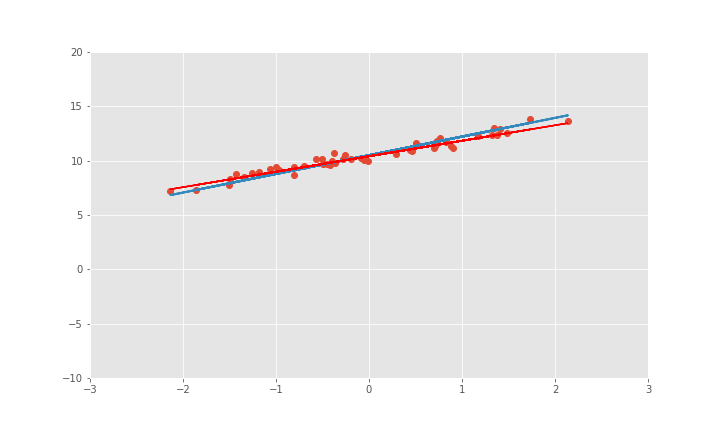
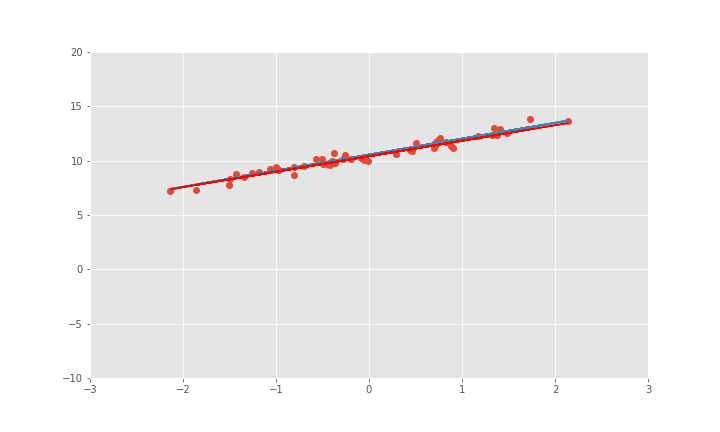
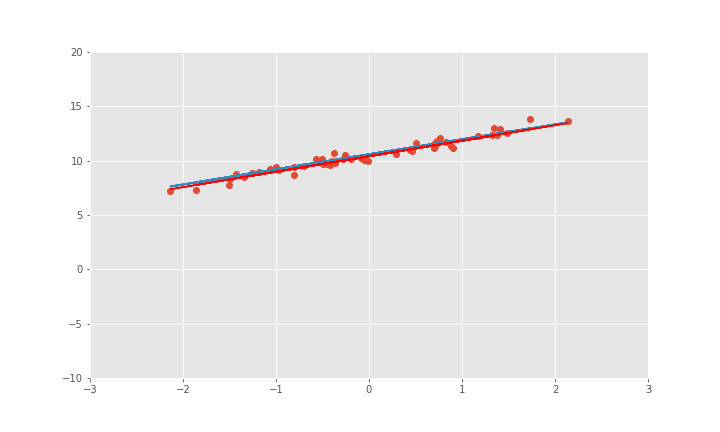
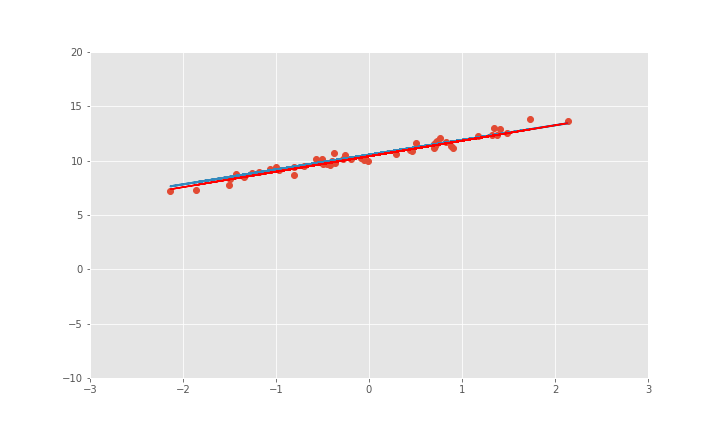
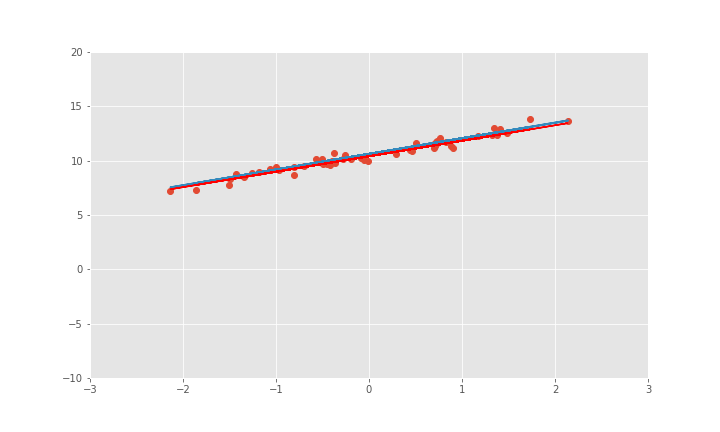
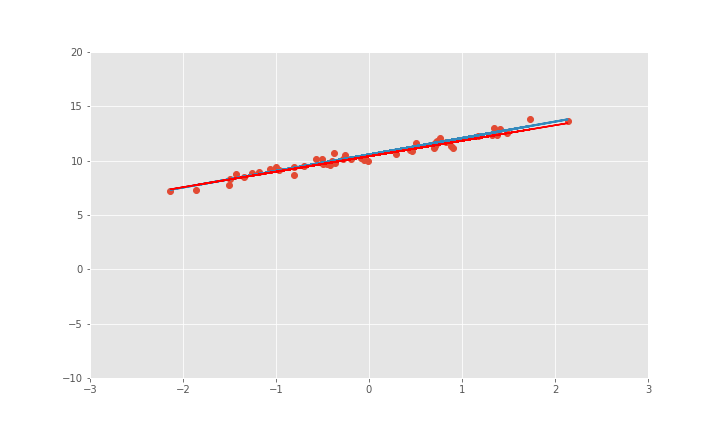
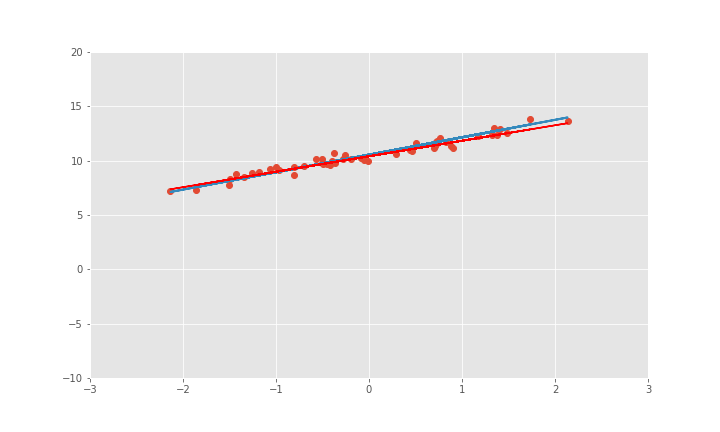
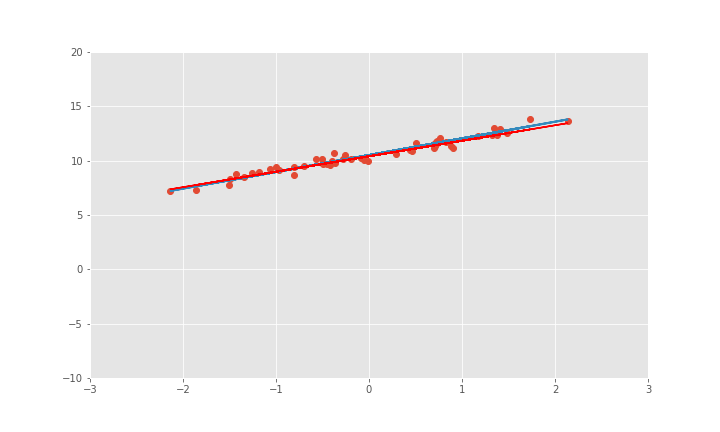
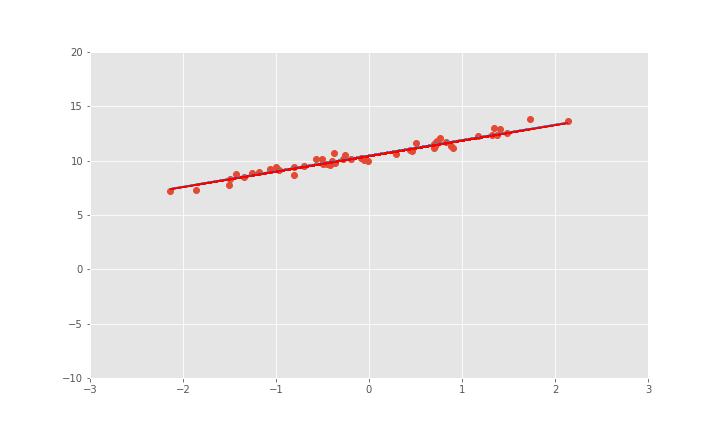
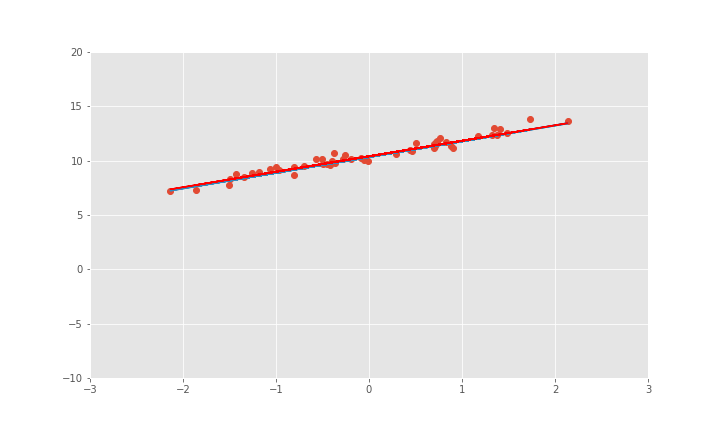
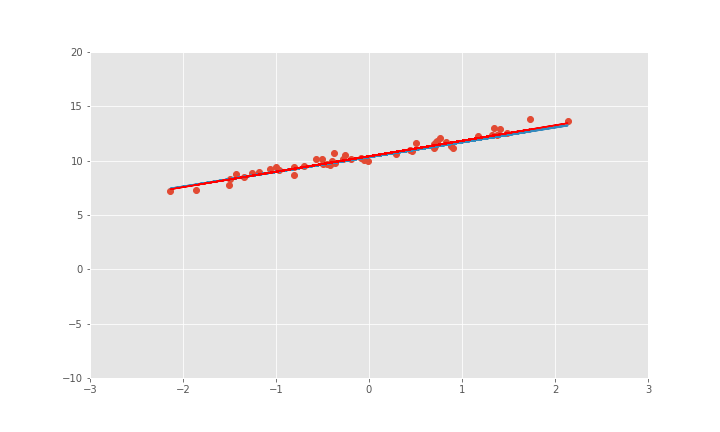
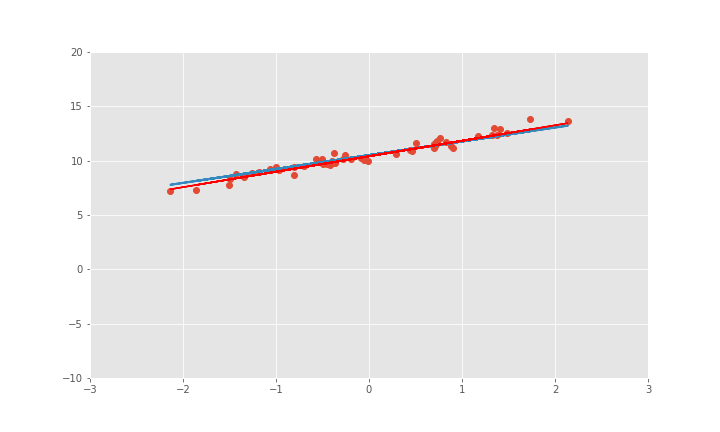
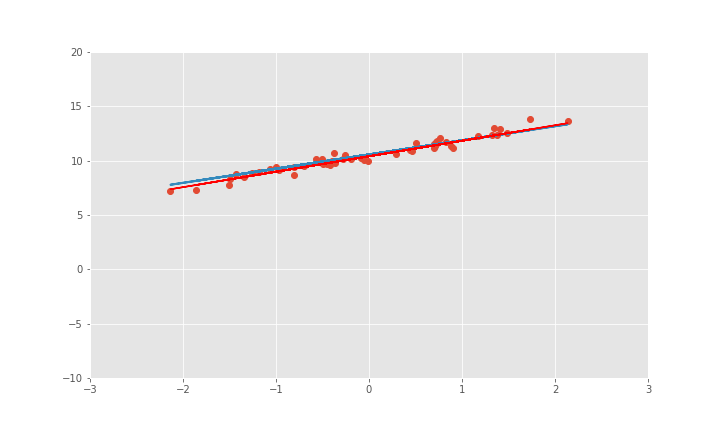
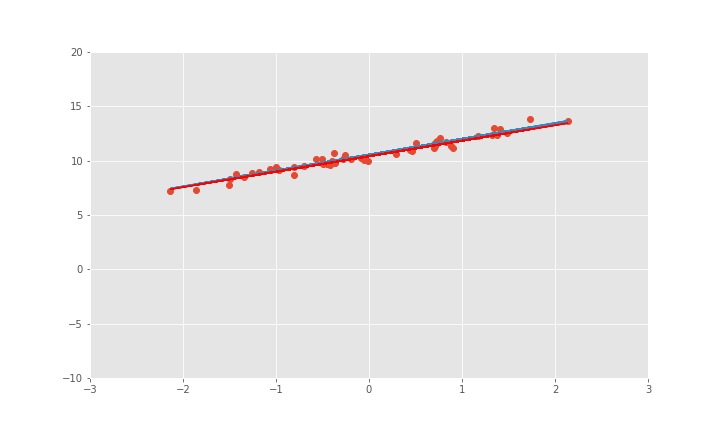
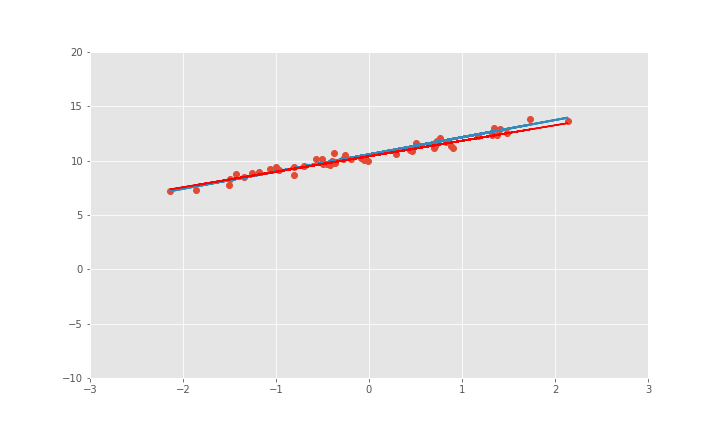
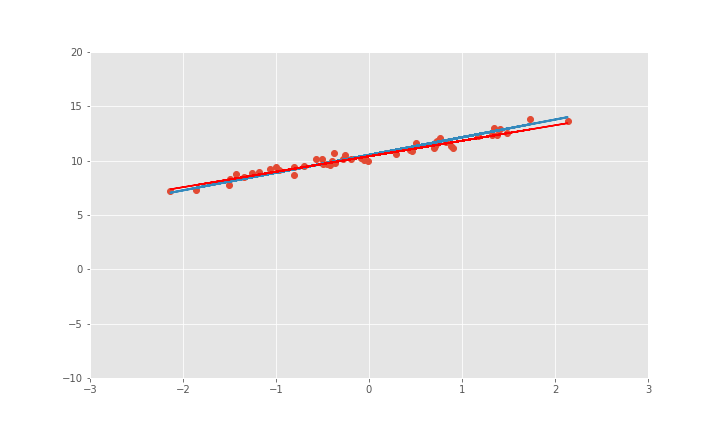
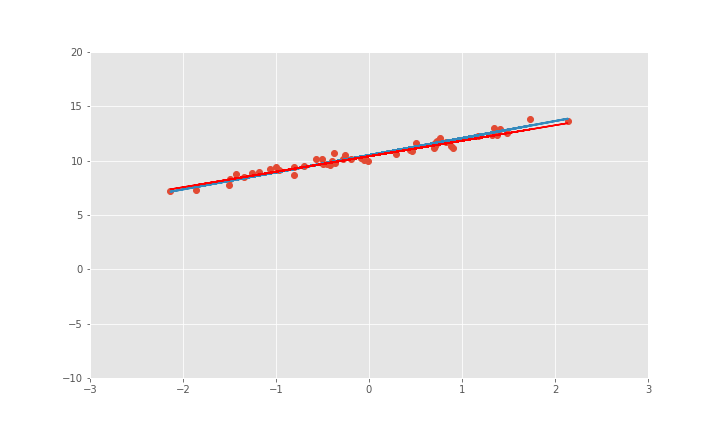
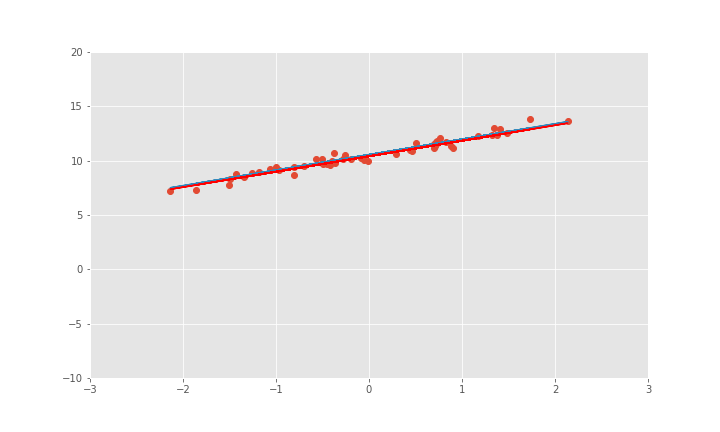
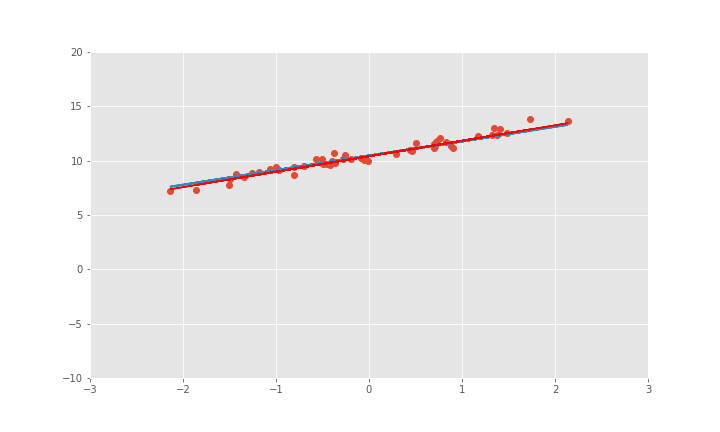
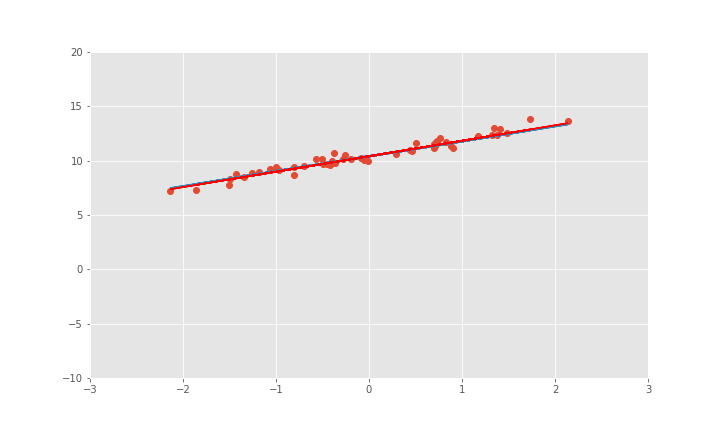
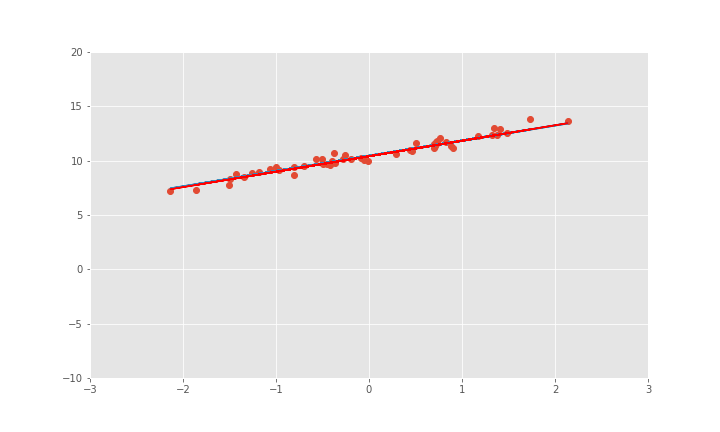
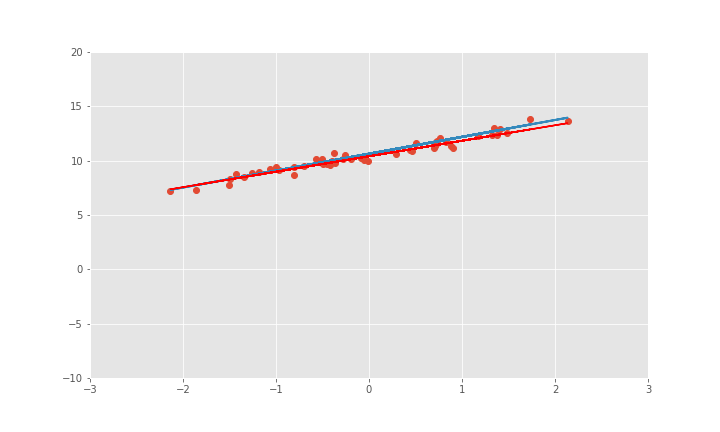
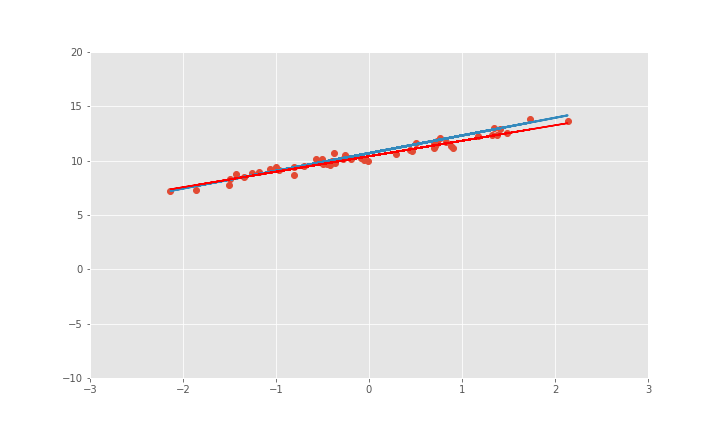
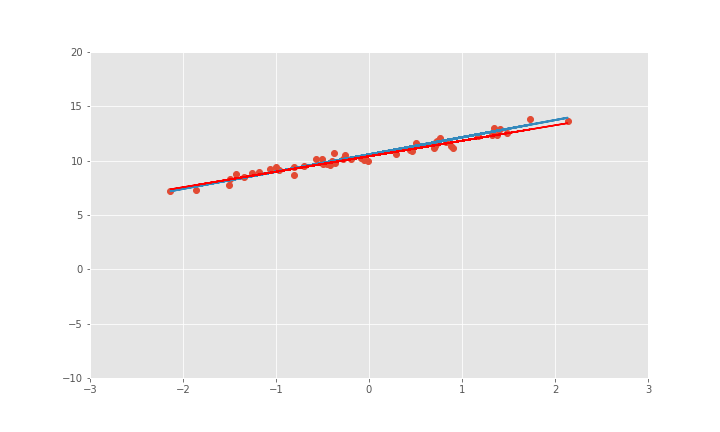
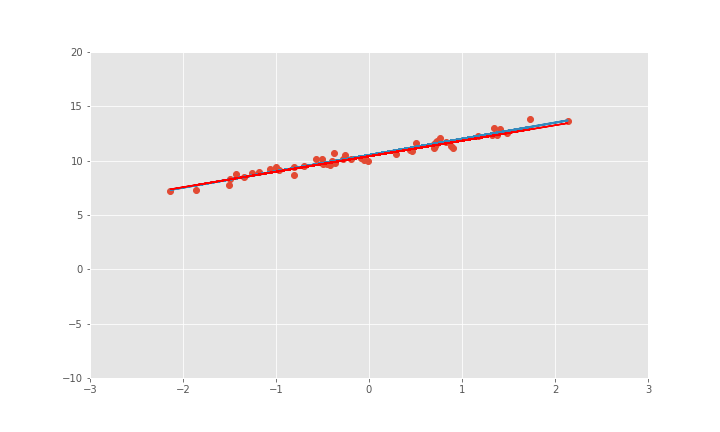
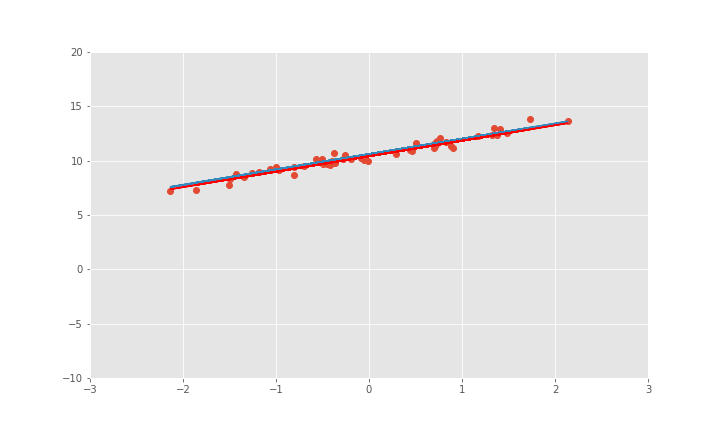
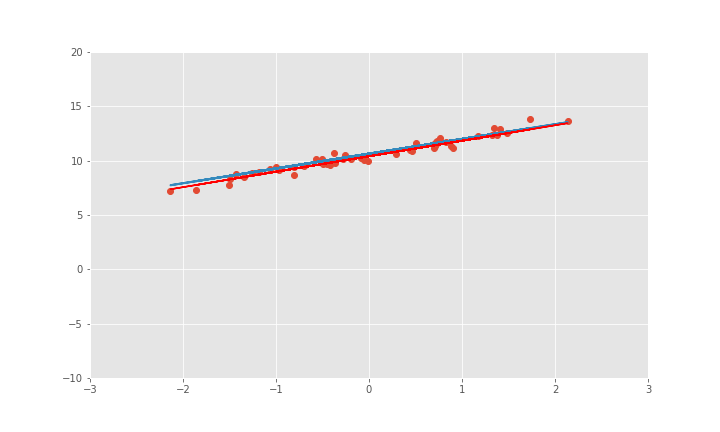
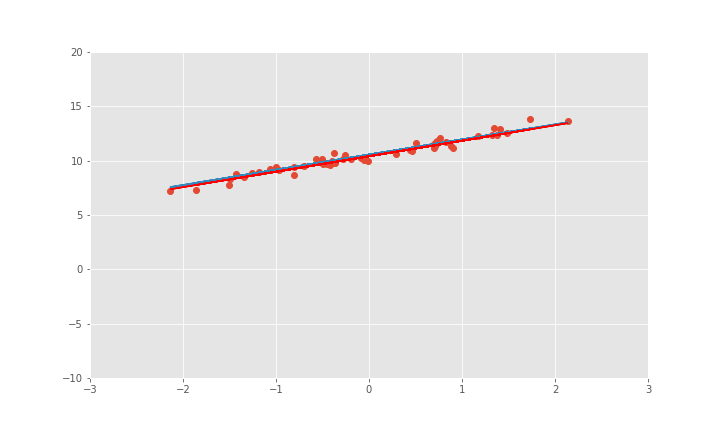
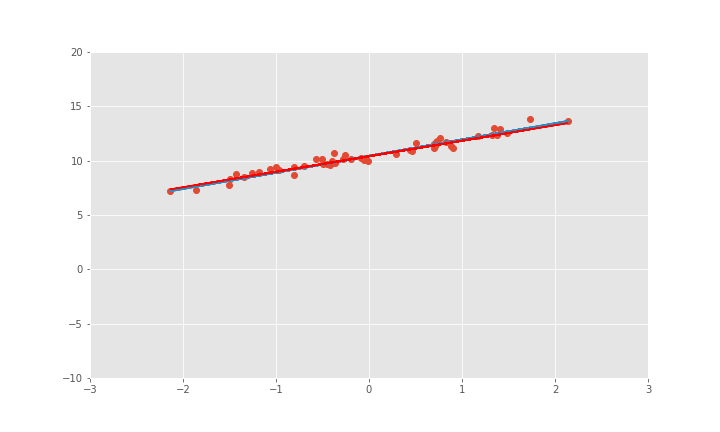
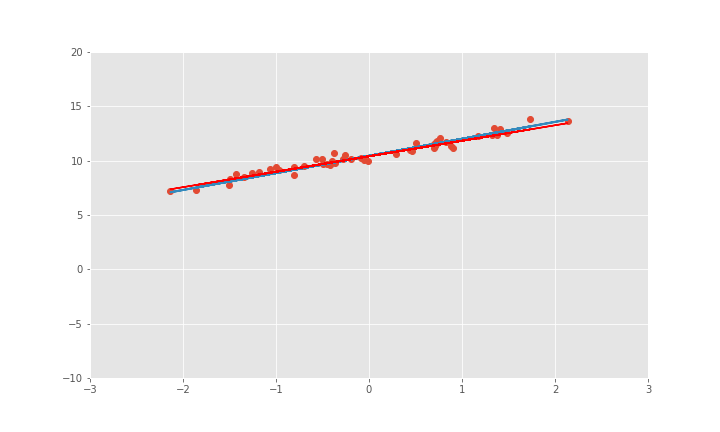
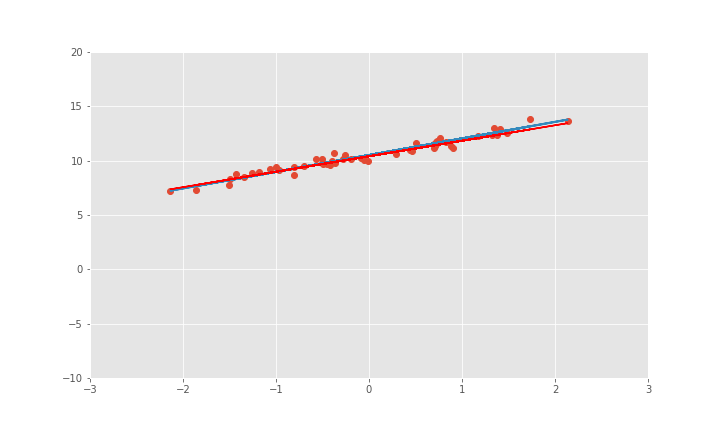
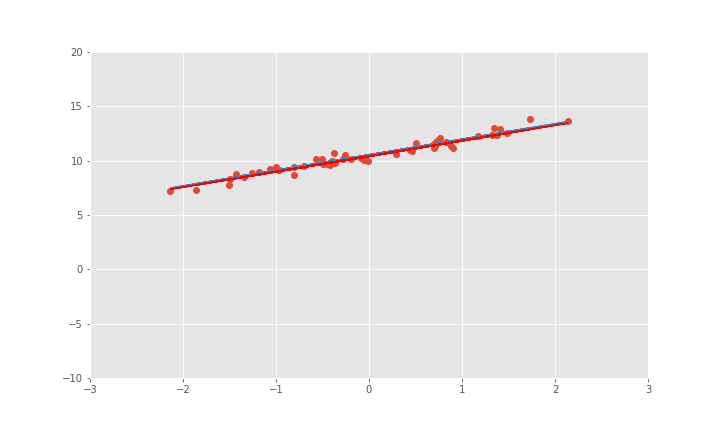
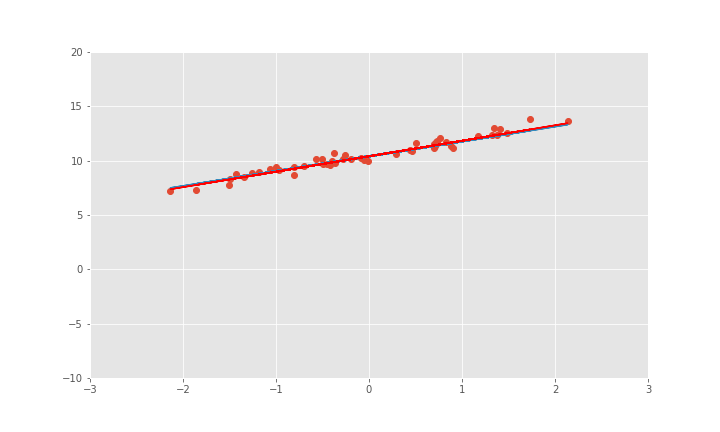
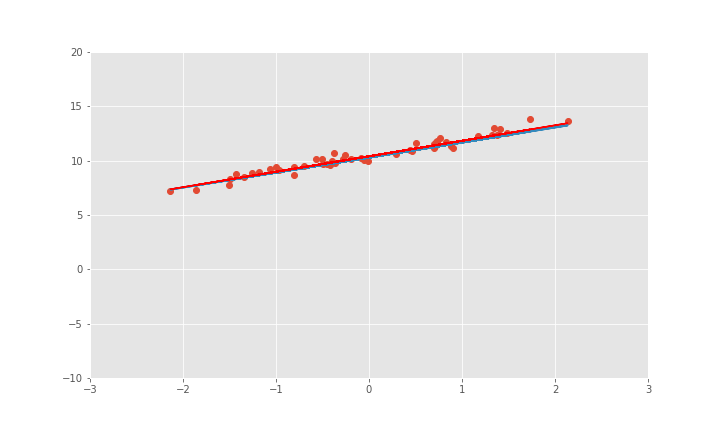
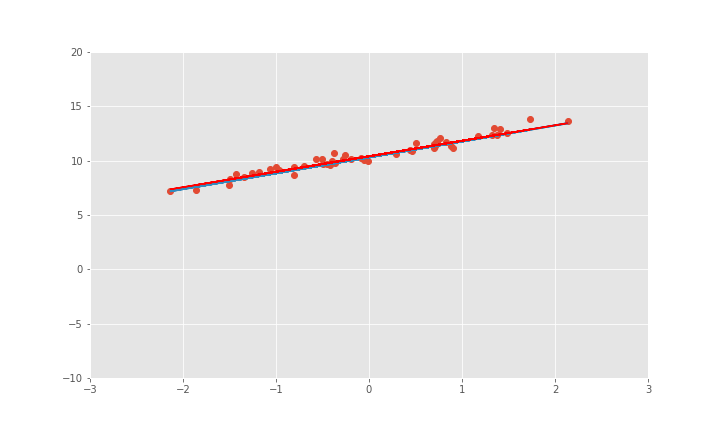
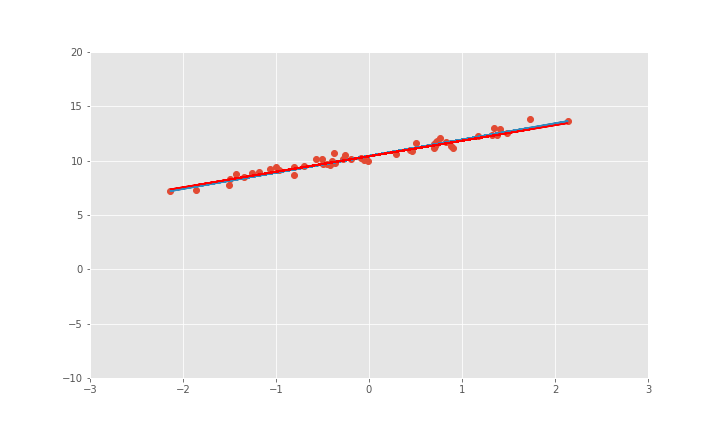
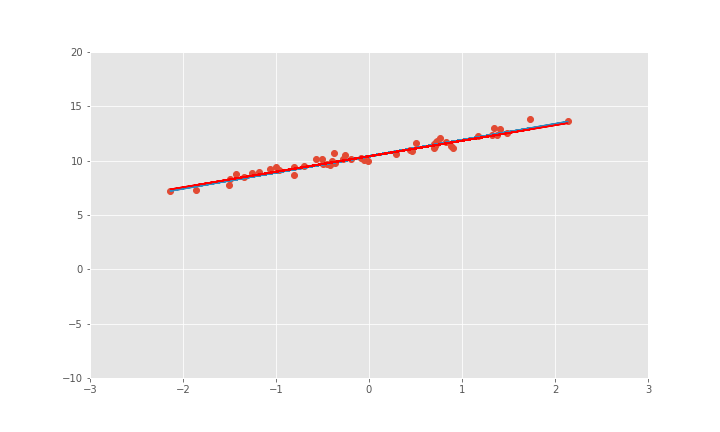
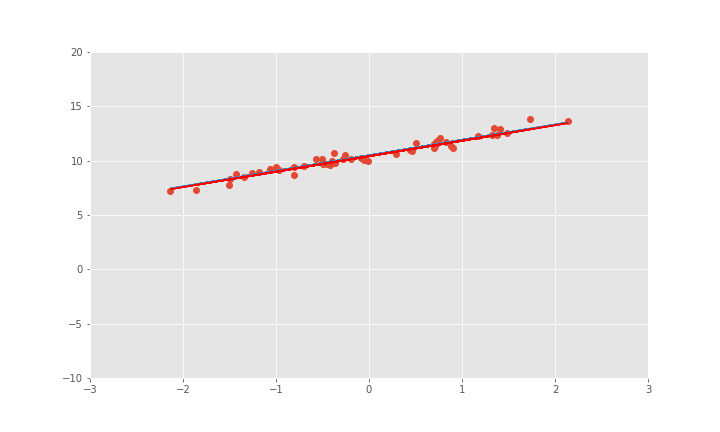
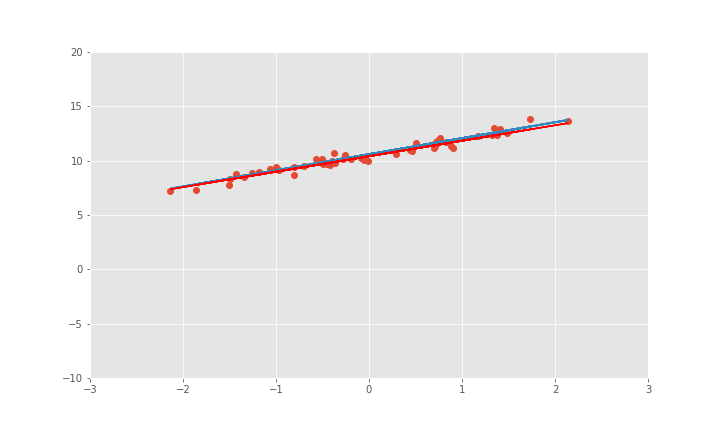
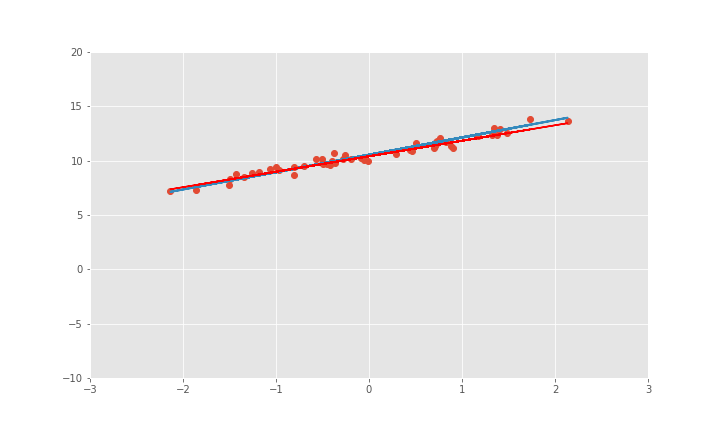
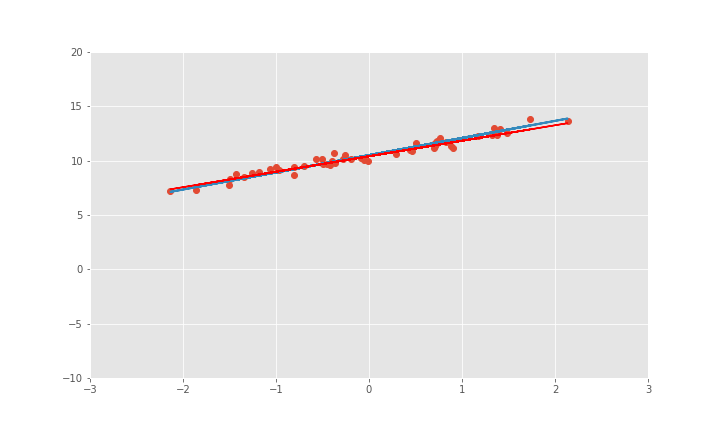
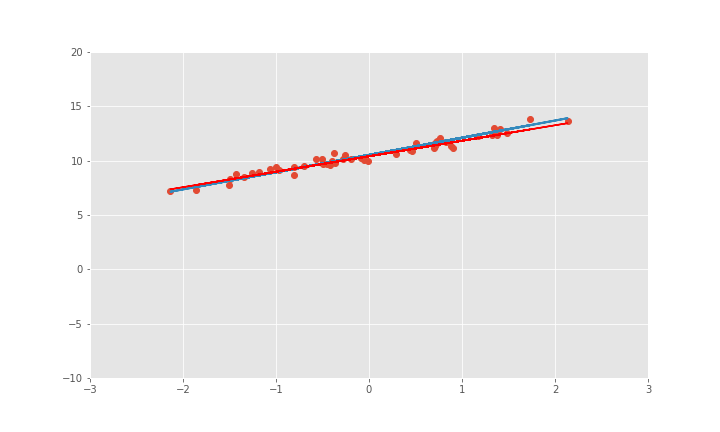
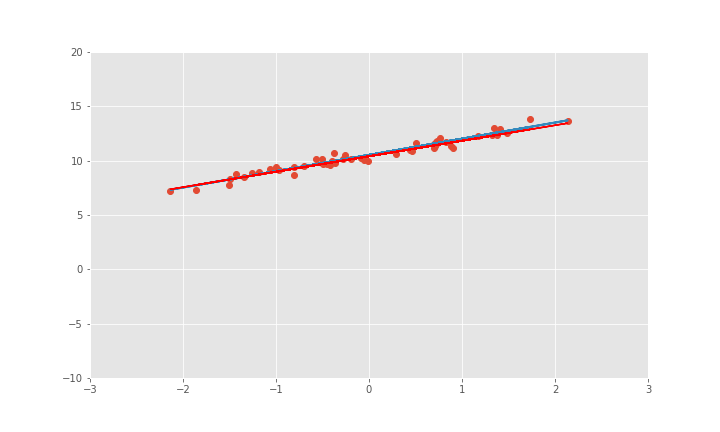
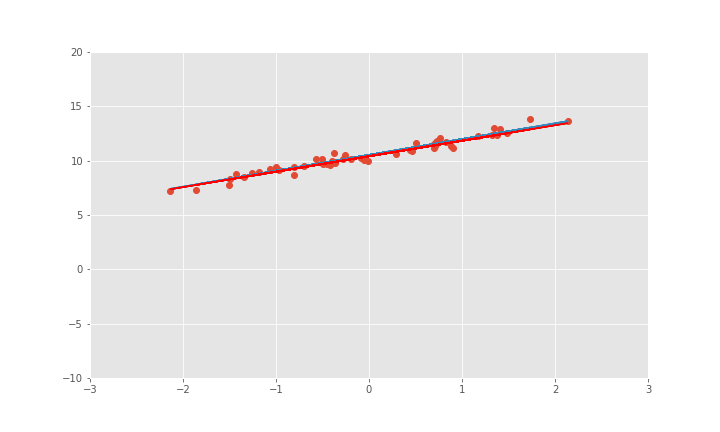
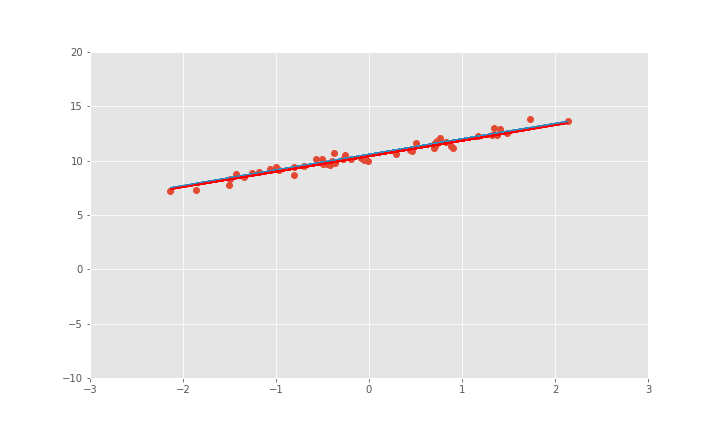
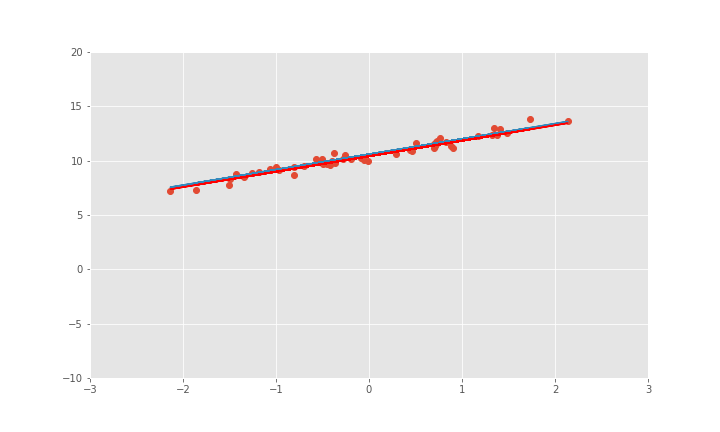
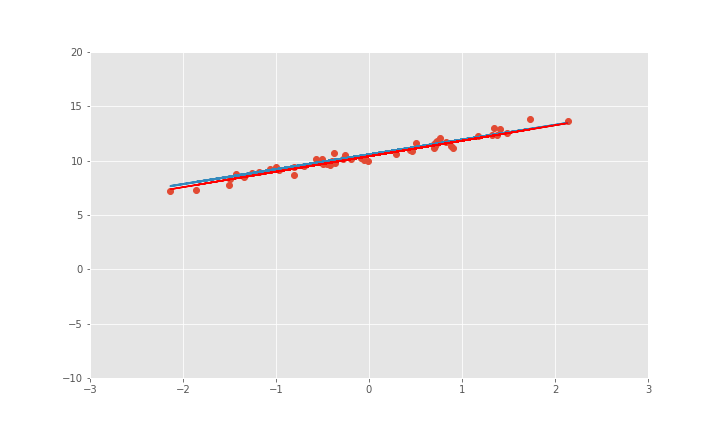
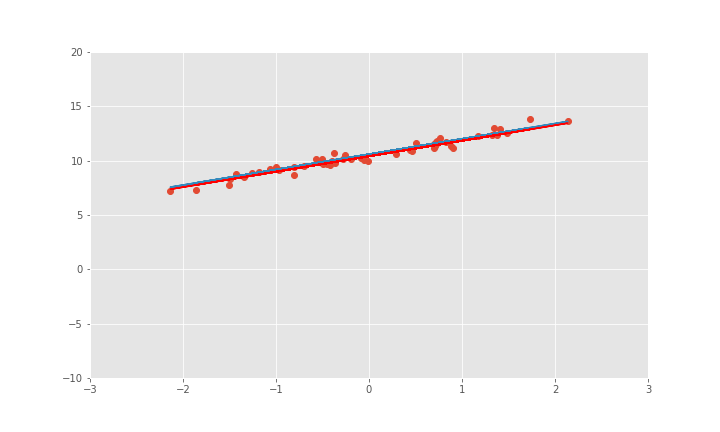
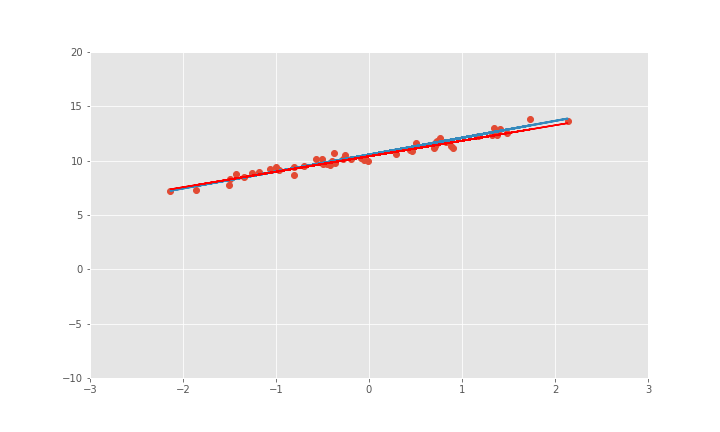
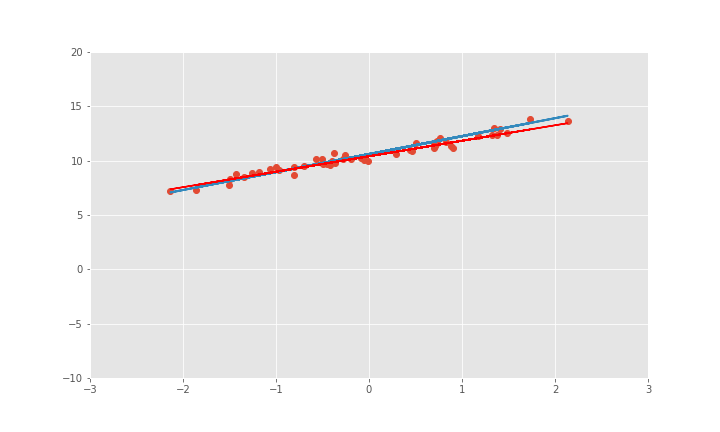
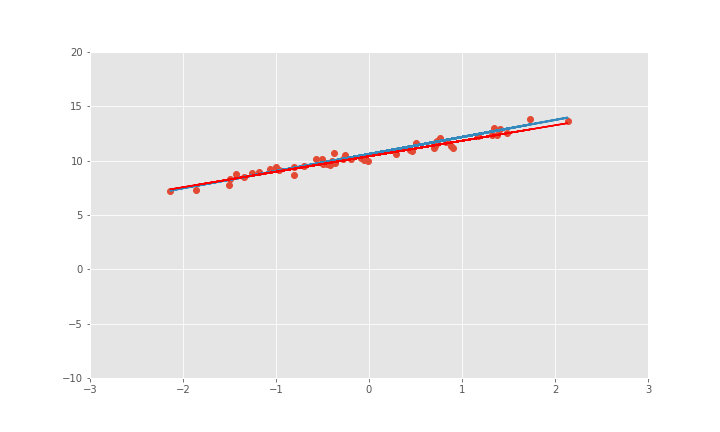
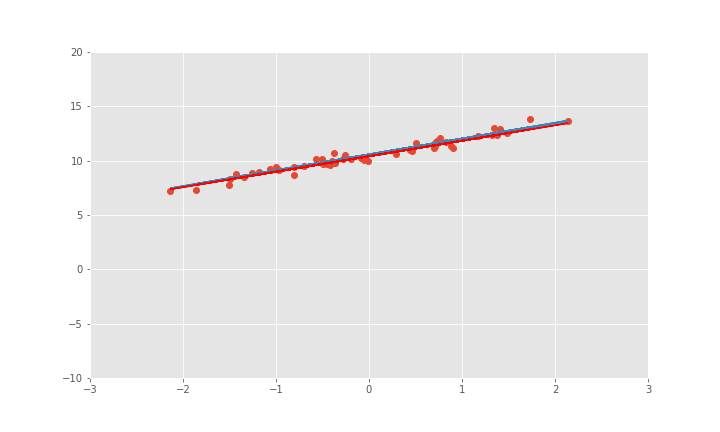
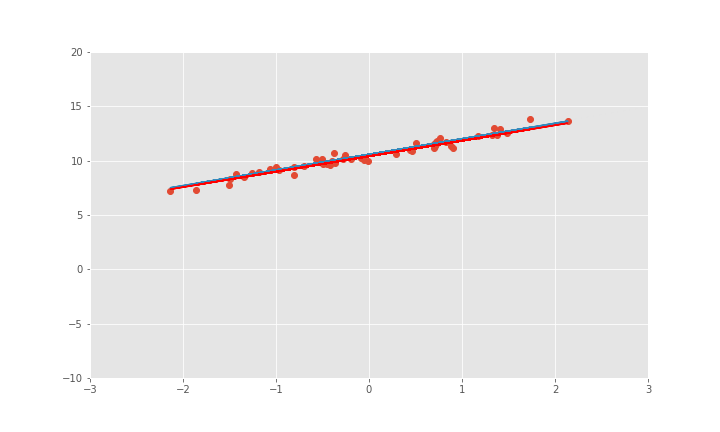
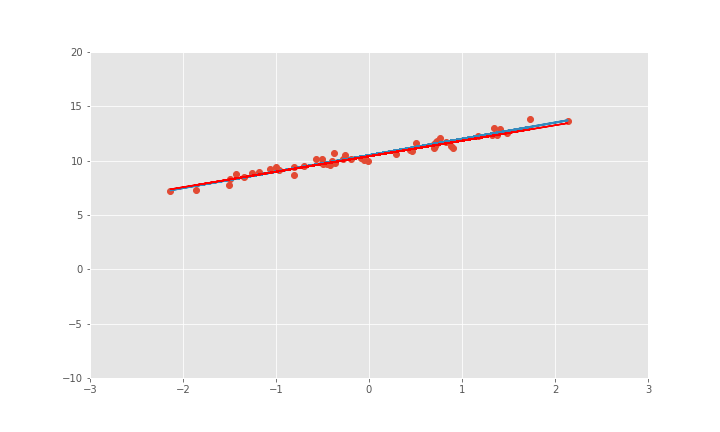
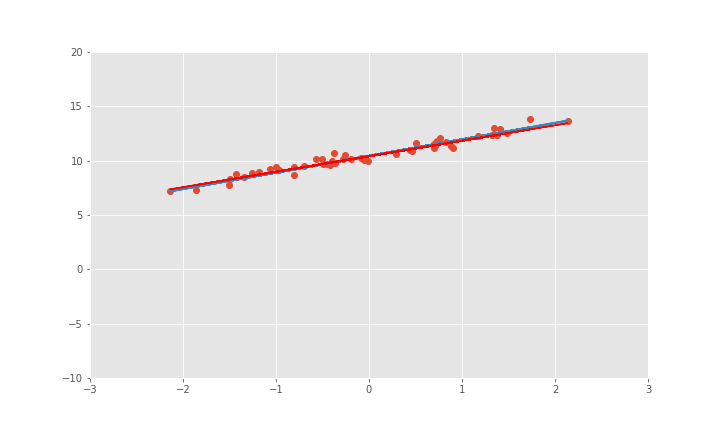
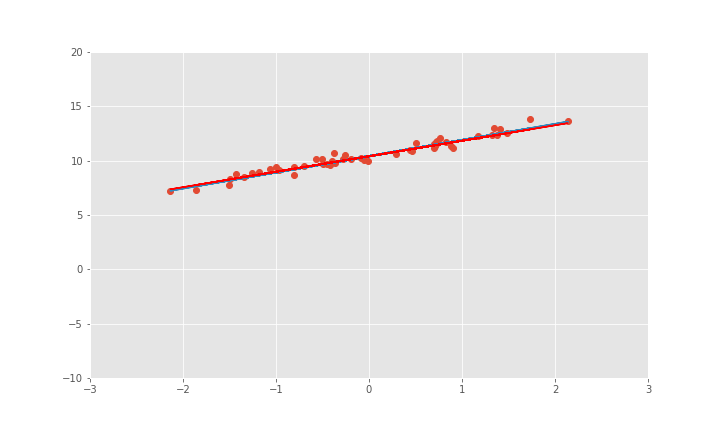
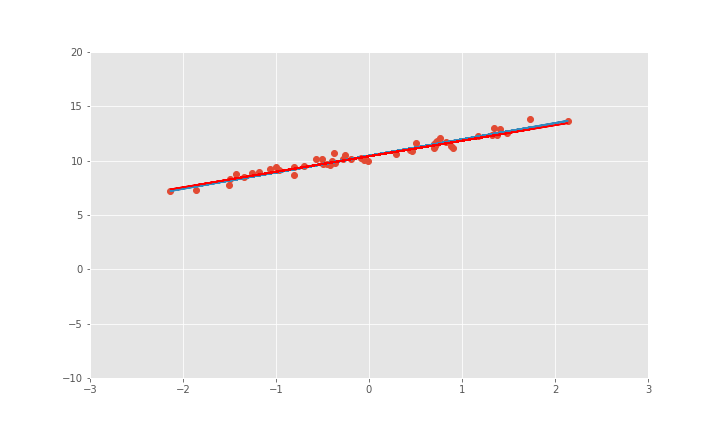
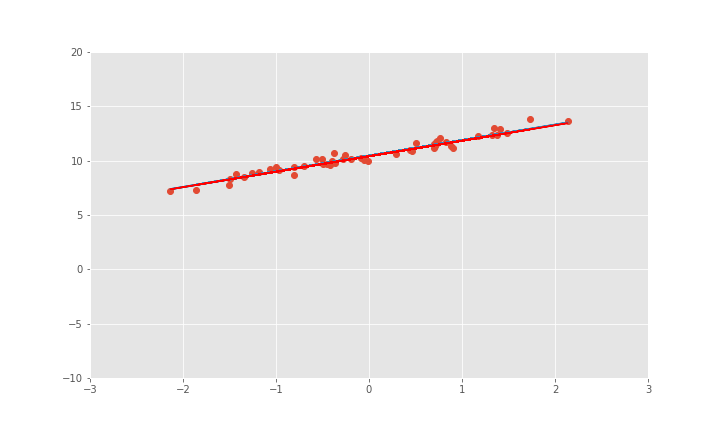
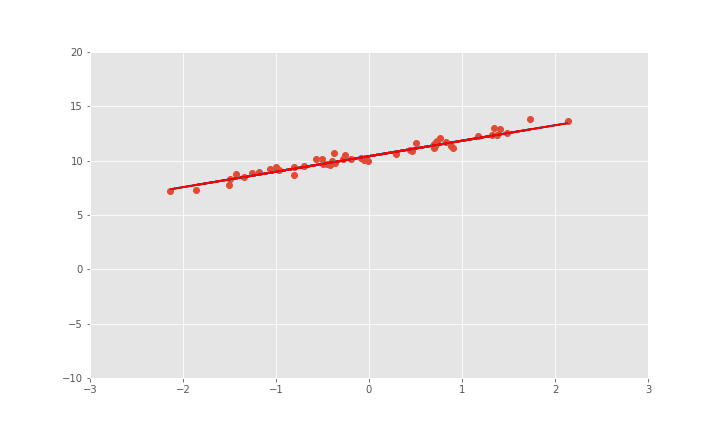

In [16]:
#Sterowanie wyświetlaniem: do history możesz wstawić history_gd albo history_sgd dla animacji tych algorytmów
# history = history_sgd
history = history_momentum

#Kod animacji, zmiany niepotrzebne
def init():
    line.set_data([], [])
    return line,

def animate(i):
    theta = history[i].reshape((-1,1))
    line.set_data(X_train[:, 0], np.dot(X_train_bias, theta))
    return line,

theta = history[-1]
best_fit_gradient_descent = theta[0] + X_train[:,0] * theta[1]
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 3), ylim=(-10, 20))
ax.plot(X_train[:,0], y_train, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(X_train[:,0], best_fit_gradient_descent, 'k-', color = "r")
animation.FuncAnimation(fig, animate, init_func=init,
                            frames=len(history), interval=100)

### Ćwiczenie 1
Tak jak w przyppadku implementacji SGD, wrócimy do problemu klasyfikacji cyferek z popularnego zbioru MNIST.

In [ ]:
X_mnist = np.genfromtxt('data/raw-image.csv', delimiter=',', skip_header=True)
y_mnist = np.genfromtxt('data/y-mnist.csv', delimiter=',', skip_header=True)

Został załadowany zbiór obrazków o wymiarach $28 \times 28$ przedstawiające pisane cyfry arabskie przez różnych ludzi. W ramce `X_mnist`, podobnie jak poprzednio, masz kolejne obserwacje (obrazki cyferek) w wierszach, a w kolumnach masz wartości kolejnych atrybutów na podstawie których będziemy dokonywać predykcji (kolejne pikseli, kolumn jest $28\cdot28=784$). W ramce `y_mnist` masz załadowany wektor zawierający cyfry, które przedstawia danych obrazek.

Napisz funkcję, która na wejście otrzyma jeden wiersz z macierzy obrazków, prztransformuje go do macierzy o wymiarach $28 \times 28$ oraz wyświetli obrazek (przydatna może być funkcja `plt.imshow`). Dodatkowo niech funkcja wyświetli prawidłowy podpis obrazka z wektora `y`.

In [ ]:
def show_img(X, y, i):
    # TWÓJ KOD na transformacje odpowiedniego wiersza
    img = ...
    print("Na obrazku jest cyfra: ", y[i])
    plt.imshow(img)
    plt.show()


# Test funkcji: wyświetl pierwszych 10 obrazków
for i in range(10):
    show_img(X_mnist, y_mnist, i)


Na razie uprościmy sobie zadanie do klasyfikacji binarnej tj. będziemy stali się automatycznie wykrywać czy na rysunku jest dana cyfra czy też nie. Z tego powodu stwórz wektor `y` zawierający 1 jeżeli obrazek zawietra cyfrę `1` oraz 0 gdy tak nie jest. Dodatkowo wykorzystując doświadczenie z poprzedniego zadania stwórz macierz `X` ze znormalizowanymi danymi (co ułatwi nam optymalizację - patrz *preconditioning*).Niestety może to nie być takie proste, bo niektóre z kolumn mają zerowe odchylenie standardowe. Nie standaryzuj także kolumny jedynek!

Ponieważ zmienna którą staramy się przewidzieć jest zmienną binarną, regresja liniowa, która przewiduje zmienne ciągłe nie jest tutaj odpowiednią techniką. Dlatego zastosujemy tutaj regresję logistyczną - nie będziemy tutaj wnikać w jej właściwości. Predykcję wykonujemy wzorem
$$f(x ,\beta)=\frac{{1}}{1+e^{-\beta^{T}x}}$$
Zwróć uwagę, że w środku tego wzoru jest wzór na regresję liniową $\beta^{T}x$ - możesz więc myśleć o tym jako obliczaniu regresji liniowej i wkładaniu jej do tego wzoru, aby wynik magicznie przerobić na *prawdopodobieństwo, że na obrazku widnieje cyfra 1*. 

Nie będziemy też minimalizować błędu kwadratowego, ale błąd wynikający z zasady maksymalnej wiarygodności. Twoim zadaniem jest zminimalizowanie funkcji:
$$\min_\beta \quad L(\beta)=\frac{{1}}{m}\sum_{i=1}^{m}\left[-y_i\log f(x_i,\beta)-(1-y_i)\log\left(1-f(x_{i} ,\beta)\right)\right]$$
gdzie $f(x)$ to ten wzór wyżej, który ma w sobie wagi $\beta$ które będziemy optymalizować.


Dodajemy kolumnę jedynek, żeby korzystać z uproszczonej notacji

In [ ]:
X = np.c_[X_mnist, np.zeros(X_mnist.shape[0])]

**Zadanie**: Zaimplementuj funkcję, która obliczy funkcję celu.

In [ ]:
def f(x, beta):
    #TWÓJ KOD funkcji logistycznej


def calc_cost(X, y, beta):
    #TWÓJ KOD funkcji celu


calc_cost(X, y, np.zeros(X.shape[1]))  # powinno wyjść ~0.693147


**Zadanie**: Zaimplementuj funkcję, która dla danego mini-batcha (fragment dużej macierzy X i wektora y) obliczy gradient.

In [ ]:
def calc_gradient(X, y, beta):
    # TWÓJ KOD

calc_gradient(X , y, np.zeros(X.shape[1])).shape # Będziemy aktualizować 28*28+1 = 785 wag, więc taka musi być długość gradientu

In [ ]:
from collections import defaultdict

def calculate_eta(t, eta, horizon):
    eta0 = eta
    eta_final = max(0.01 * eta0, 0.00001)
    eta = (1- t/horizon) * eta0 + (t/horizon) * eta_final
    if t > horizon:
        eta = eta_final
    return eta

def stochastic_gradient_descent(X, y, max_iter, eta, horizon, batch_size, momentum_mu=0, nesterov=False, 
                                rmsprop=False, rmsprop_mu=0.9):
    historical_data = defaultdict(list)
    historical_data['X'] = X
    historical_data['y'] = y
    
    beta = np.zeros(X.shape[1])
    momentum = np.zeros_like(beta)
    gradient_accumulator = np.zeros_like(beta)
    i = 0
    for t in range(max_iter):
        if i >= X.shape[0]:
            i = 0

        eta_t = calculate_eta(t, eta, horizon)
        if nesterov and momentum_mu > 0:
            # TWÓJ KOD
            pass
        else:
            # TWÓJ KOD
            pass
        if rmsprop:
            # TWÓJ KOD
            pass
            
        
        beta = ...  # TWÓJ KOD krok algorytmu
        i += batch_size
        
        historical_data['solutions'].append(beta)
        historical_data['eta_history'].append(eta_t)
        historical_data['gradients'].append(gradient)
    historical_data['final_solution'] = beta
    return historical_data


eta_start = 0.001
sgd_data = stochastic_gradient_descent(X, y, 
                                        max_iter = int(X.shape[0]*2/100),
                                        eta = eta_start, horizon = X.shape[0]*2/100, batch_size = 100)

rmsprop_data = stochastic_gradient_descent(X, y, 
                                        max_iter = int(X.shape[0]*2/100),
                                        eta = eta_start, horizon = X.shape[0]*2/100, batch_size = 100,
                                        rmsprop=True)
sgd_momentum_data = stochastic_gradient_descent(X, y, 
                                        max_iter = int(X.shape[0]*2/100),
                                        eta = eta_start, horizon = X.shape[0]*2/100, batch_size = 100,
                                        momentum_mu=0.99,
                                        nesterov=True)
sgd_data["label"] = "sgd"
rmsprop_data["label"] = "rmsprop"
sgd_momentum_data["label"] = "momentum"

from helpers import plot_algorithm_stats
plot_algorithm_stats([sgd_data, rmsprop_data, sgd_momentum_data], calc_cost, False)
